## &#x1F680; Project Title: 2024 Music Analytics - Insights on Tracks, Albums, and Genres Using Spotify API Data &#x1F680;

**Author:**
* Fernandez Arista, Diego Alonso<br>

**Date:** 
* January 22nd, 2025

---

## Table of Contents &#x1F680;
1. [**Introduction**](#item)
   - 1.1 Project Overview
   - 1.2 Data Collection Methodology
   - 1.3 Analysis Framework<br><br>

2. [**Data Extraction and Preparation**](#item-two)
   - 2.1 [Libraries](#item-three)
   - 2.2 [Connecting to the Spotify API](#item-four)
   - 2.3 [Extracting and Saving Data](#item-five)
     - 2.3.1 Album Data
     - 2.3.2 Song Data
     - 2.3.3 Artist Data
   - 2.4 [Data Merging and Preparation](#item-six)<br><br>

3. [**Exploring Trends in Song and Album Popularity**](#item-seven)
   - 3.1 [Trends in Song Popularity and Influencing Factors](#item-eight)
   - 3.2 [Trends in Album Popularity and Influencing Factors](#item-nine)<br><br>

4. [**Statistical Analysis of Album Popularity**](#item-ten)
   - 4.1 [Comparison of Albums with Track Count Above vs Below Median](#item-eleven)
   - 4.2 [Comparison of Albums with Featurings Above vs Below Median](#item-twelve)
   - 4.3 [Comparison of Albums with Time Since Release Above vs Below 4 Months](#item-twelve2)<br><br>
   

5. [**Correlation Between Artist Followers and Album Popularity**](#item-thirteen)<br><br>

6. [**Genre-Based Correlation Analysis: Artist Followers, Total Tracks, and Album Popularity with Respect to Album Popularity**](#item-fourteen)
   - 6.1 [Most Common Genres in 2024 Albums](#item-fifteen)
   - 6.2 [Correlations in Top 5 Most Common Genres](#item-sixteen)
   - 6.3 [Correlations in Personal Favorite Genres](#item-seventeen)<br><br>

7. [**Conclusions and Insights**](#item-eighteen)
   - 7.1 [Insights on Trends and Influencing Factors for Song and Album Popularity (Part 3)](#item-nineteen)
   - 7.2 [Key Findings from Statistical Analysis of Album Popularity (Part 4)](#item-twenty)
   - 7.3 [Implications from Correlation Between Artist Followers and Album Popularity (Part 5)](#item-twenty-one)
   - 7.4 [Genre-Based Correlation Analysis and Broader Implications (Part 6)](#item-twenty-two)
   
---

## 1. Introduction &#x1F680; <a id="item"></a>

### 1.1 Project Overview
- This project investigates trends in song and album popularity for 2024 releases on Spotify, focusing on factors like song duration, release month, track count, featuring artists, and artist followers. Using data collected through the Spotify API, it aims to identify key elements that influence streaming success and offer insights into current music industry trends.

### 1.2 Data Collection Methodology
- Data was collected from the Spotify API, which provided detailed information on albums, songs, and artists from 2024 releases. Album details, including track count and popularity, were gathered alongside song-level data such as track popularity, duration, and artist information, all saved in pickle files for easy analysis.

### 1.3 Limitations
- **Spotify API Constraints**: The Spotify API limits the number of albums returned for a specific year to a maximum of 1,000 rows. This restriction affects the comprehensiveness of the dataset, as it may not capture all albums released in 2024.
- **Album Types**: The analysis focuses solely on albums, excluding singles and EPs, which might also influence trends in the music industry.
- **Genre Information**: Genres are assigned to artists rather than individual albums or tracks. Additionally, only 263 out of 443 albums (59.37%) in the dataset have associated genre information, which limits the scope of genre-based analysis, especially in Section 6.
- **Statistical Assumptions**: The statistical analysis (e.g., one-sided t-tests in Section 4) assumes normality and equal variance, which may not hold for all subsets of the data.

---

## 2. Data Extraction and Preparation &#x1F680; <a id="item-two"></a>

### 2.1. Libraries <a id="item-three"></a>

In [1]:
import time
import pickle

from scipy import stats
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import ast

import warnings
warnings.filterwarnings('ignore')

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

### 2.2. Connecting to the Spotify API <a id="item-four"></a>

In [2]:
client_id = 'bd1b51826b36451c8fc7faa64e9fd33b'
client_secret = '8b1730e86e6d455ab3f6b31e892c26a3'

manager_key = SpotifyClientCredentials(client_id = client_id,client_secret = client_secret)
sp = spotipy.Spotify(client_credentials_manager = manager_key)

### 2.3. Extracting and Saving Data <a id="item-five"></a>

#### 2.3.1. Album Data

In [13]:
# Album data from Spotify from 2024 year
album_data = []

for offset in range(0,1000,50):
    results = sp.search(q='year:2024', type='album', limit=50, offset=offset)

    for album in results['albums']['items']:
        album_data.append({
            'album_id':album['id'],
            'album_name':album['name'],
            'album_artist_id':album['artists'][0]['id'],
            'album_artist_name':album['artists'][0]['name'],
            'album_total_tracks':album['total_tracks'],
            'album_release_date':album['release_date'],
            'album_type':album['album_type']
        })

album_data_filtered = [album for album in album_data if album['album_type'] == 'album']

# Save the data into a pickle file
with open('album_data_filtered.pkl','wb') as file:
    pickle.dump(album_data_filtered, file)

print("Data has been saved to 'album_data_filtered.pkl'")

#### 2.3.2. Song Data

In [15]:
# Songs data from Spotify's albums of 2024 year (album_popularity, song_id, song_name, song_duration_ms)
album_data_filtered_ids = [album['album_id'] for album in album_data_filtered]
songs_album_info = []

for id in range(0,len(album_data_filtered_ids),20):
    batch_ids = album_data_filtered_ids[id:id + 20]
    results = sp.albums(batch_ids)

    for album in results['albums']:
        for tracks in album['tracks']['items']:
            songs_album_info.append({
                'album_id':album['id'],
                'album_popularity':album['popularity'],
                'song_id':tracks['id'],
                'song_name':tracks['name'],
                'song_duration_ms':tracks['duration_ms']
            })

    time.sleep(0.5)

# Save the data into a pickle file
with open('songs_album_info.pkl','wb') as file:
    pickle.dump(songs_album_info, file)

print("Data has been saved to 'songs_album_info.pkl'")

In [17]:
# Songs extra data from Spotify's albums of 2024 year (song_artists, song_popularity)
songs_id = [track['song_id'] for track in songs_album_info]

artists_list = []
songs_with_extra_info = []

for track_id in range(0,len(songs_id),50):
    batch_track_ids = songs_id[track_id:track_id+50]
    results_tracks = sp.tracks(batch_track_ids)
    for track in results_tracks['tracks']:
        artists_list = [
            {'artist_id': artist['id'], 'artist_name': artist['name']}
            for artist in track['artists']
        ]
        songs_with_extra_info.append({
            'song_id':track['id'],
            'song_artists':artists_list,
            'song_popularity':track['popularity']
        })

# Save the data into a pickle file
with open('songs_with_extra_info.pkl','wb') as file:
    pickle.dump(songs_with_extra_info, file)

print("Data has been saved to 'songs_with_extra_info.pkl'")

#### 2.3.3. Artist Data

In [230]:
# Artists extra data from Spotify's albums of 2024 year (album_artist_followers, album_artist_genres)
artists_id = list(set([album['album_artist_id'] for album in album_data_filtered]))

artists_with_extra_info = []

for artist_id in range(0,len(artists_id),50):
    batch_artist_ids = artists_id[artist_id:artist_id+50]
    results_artists = sp.artists(batch_artist_ids)
    for artist in results_artists['artists']:
        artists_with_extra_info.append({
            'album_artist_id':artist['id'],
            'album_artist_followers':artist['followers']['total'],
            'album_artist_genres':artist['genres']
        })

# Save the data into a pickle file
with open('artists_with_extra_info.pkl','wb') as file:
    pickle.dump(artists_with_extra_info, file)

print("Data has been saved to 'artists_with_extra_info.pkl'")

### 2.4. Data Merging and Preparation <a id="item-six"></a>

In [26]:
# Reading pickle file previously saved
with open('album_data_filtered.pkl','rb') as file:
    loaded_album_data_filtered = pickle.load(file)

# Reading pickle file previously saved
with open('songs_album_info.pkl','rb') as file:
    loaded_songs_album_info = pickle.load(file)

# Reading pickle file previously saved
with open('songs_with_extra_info.pkl','rb') as file:
    loaded_songs_with_extra_info = pickle.load(file)

# Reading pickle file previously saved
with open('artists_with_extra_info.pkl','rb') as file:
    loaded_artists_with_extra_info = pickle.load(file)

In [27]:
loaded_songs_with_extra_info_ID = {song['song_id']: song for song in loaded_songs_with_extra_info}

combined_list_v1 = [
    {**track, **loaded_songs_with_extra_info_ID.get(track['song_id'], {})} for track in loaded_songs_album_info
]

loaded_album_data_filtered_ID = {album['album_id']: album for album in loaded_album_data_filtered}

combined_list_v2 = [
    {**album, **loaded_album_data_filtered_ID.get(album['album_id'], {})} for album in combined_list_v1
]

loaded_artists_with_extra_info_ID = {artist['album_artist_id']: artist for artist in loaded_artists_with_extra_info}

combined_list_vf = [
    {**artist, **loaded_artists_with_extra_info_ID.get(artist['album_artist_id'], {})} for artist in combined_list_v2
]

In [28]:
df_spotify_data_2024 = pd.DataFrame(combined_list_vf)[[
                                                        'song_id', 
                                                        'song_name', 
                                                        'song_artists',
                                                        'song_popularity',
                                                        'song_duration_ms',
                                                        'album_id',
                                                        'album_name',
                                                        'album_artist_id',
                                                        'album_artist_name',
                                                        'album_artist_followers',
                                                        'album_artist_genres',
                                                        'album_total_tracks',
                                                        'album_popularity',
                                                        'album_release_date'
                                                        ]]

In [29]:
# Now drop duplicates
df_spotify_data_2024['song_artists'] = df_spotify_data_2024['song_artists'].astype(str)
df_spotify_data_2024['album_artist_genres'] = df_spotify_data_2024['album_artist_genres'].astype(str)

df_spotify_data_2024 = df_spotify_data_2024.drop_duplicates()

In [30]:
df_spotify_data_2024['album_number_featuring'] = df_spotify_data_2024['song_artists'].apply(ast.literal_eval).apply(lambda x: 1 if len(x) > 1 else 0)
df_spotify_data_2024_album_level = df_spotify_data_2024.groupby(['album_id',
                                                       'album_name',
                                                       'album_artist_id',
                                                       'album_artist_name',
                                                       'album_artist_genres',
                                                       'album_artist_followers',
                                                       'album_total_tracks',
                                                       'album_release_date',
                                                       'album_popularity'])[['album_number_featuring']].sum().reset_index() 

In [31]:
# Getting back to what it used to be, to be able to treat them as they are
df_spotify_data_2024['song_artists'] = df_spotify_data_2024['song_artists'].apply(ast.literal_eval)
df_spotify_data_2024['album_artist_genres'] = df_spotify_data_2024['album_artist_genres'].apply(ast.literal_eval)

df_spotify_data_2024_album_level['album_artist_genres'] = df_spotify_data_2024_album_level['album_artist_genres'].apply(ast.literal_eval)

---
## 3. Exploring Trends in Song and Album Popularity &#x1F680; <a id="item-seven"></a>

### 3.1. Trends in Song Popularity and Influencing Factors <a id="item-eight"></a>

**Question** = How do song duration and release month influence song popularity in 2024 releases?

In [32]:
# STEP 1: EXPLORE THE DATA

# Summary statistics
popularity_summary = df_spotify_data_2024[['song_popularity', 'song_duration_ms']].describe()
print("Summary Statistics:\n", popularity_summary)

# Check for missing values
missing_values = df_spotify_data_2024[['song_popularity', 'song_duration_ms']].isnull().sum()
print("\nMissing Values:\n", missing_values)

# Change 'album_release_date' to datetime and check the data types of the other columns
df_spotify_data_2024['album_release_date'] = pd.to_datetime(df_spotify_data_2024['album_release_date'])
print("\nData Types:\n")
df_spotify_data_2024.info()

Summary Statistics:
        song_popularity  song_duration_ms
count      6903.000000       6903.000000
mean         51.778647     179355.103578
std          12.510371      60953.263198
min           0.000000       7402.000000
25%          44.000000     146486.000000
50%          52.000000     178588.000000
75%          59.000000     210875.000000
max          97.000000     875306.000000

Missing Values:
 song_popularity     0
song_duration_ms    0
dtype: int64

Data Types:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6903 entries, 0 to 6934
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   song_id                 6903 non-null   object        
 1   song_name               6903 non-null   object        
 2   song_artists            6903 non-null   object        
 3   song_popularity         6903 non-null   int64         
 4   song_duration_ms        6903 non-null   int64    

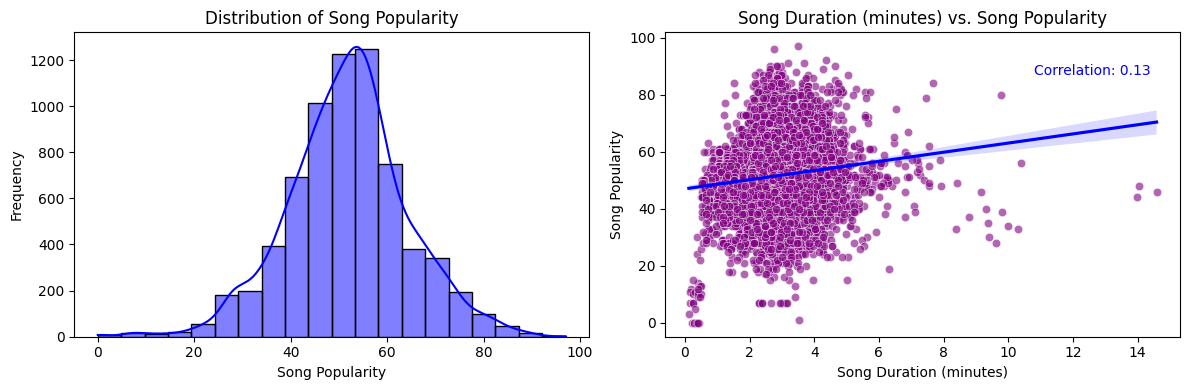

In [33]:
# STEP 2: "TRENDS IN SONG POPULARITY" AND "SONG DURATION AND POPULARITY"

fig, axes = plt.subplots(1, 2, figsize=(12,4))

# PART A: "TRENDS IN SONG POPULARITY"
sns.histplot(df_spotify_data_2024['song_popularity'], bins=20, kde=True, color='blue', ax=axes[0])
axes[0].set_title('Distribution of Song Popularity')
axes[0].set_xlabel('Song Popularity')
axes[0].set_ylabel('Frequency')

# PART B: "SONG DURATION AND POPULARITY"
sns.scatterplot(
    x=df_spotify_data_2024['song_duration_ms'] / 60000, # Convert ms to minutes
    y=df_spotify_data_2024['song_popularity'],
    alpha=0.6, color='purple'
)
sns.regplot(
    x=df_spotify_data_2024['song_duration_ms'] / 60000, # Convert ms to minutes
    y=df_spotify_data_2024['song_popularity'],
    scatter=False,
    color='blue'
)

correlation = (df_spotify_data_2024['song_duration_ms'] / 60000).corr(df_spotify_data_2024['song_popularity'])

axes[1].set_title('Song Duration (minutes) vs. Song Popularity')
axes[1].set_xlabel('Song Duration (minutes)')
axes[1].set_ylabel('Song Popularity')
axes[1].text(x=axes[1].get_xlim()[1] - 4.5,
         y=axes[1].get_ylim()[1] - 15,
         s=f'Correlation: {correlation:.2f}',
         fontsize=10, 
         color='blue')

plt.tight_layout()
plt.show()

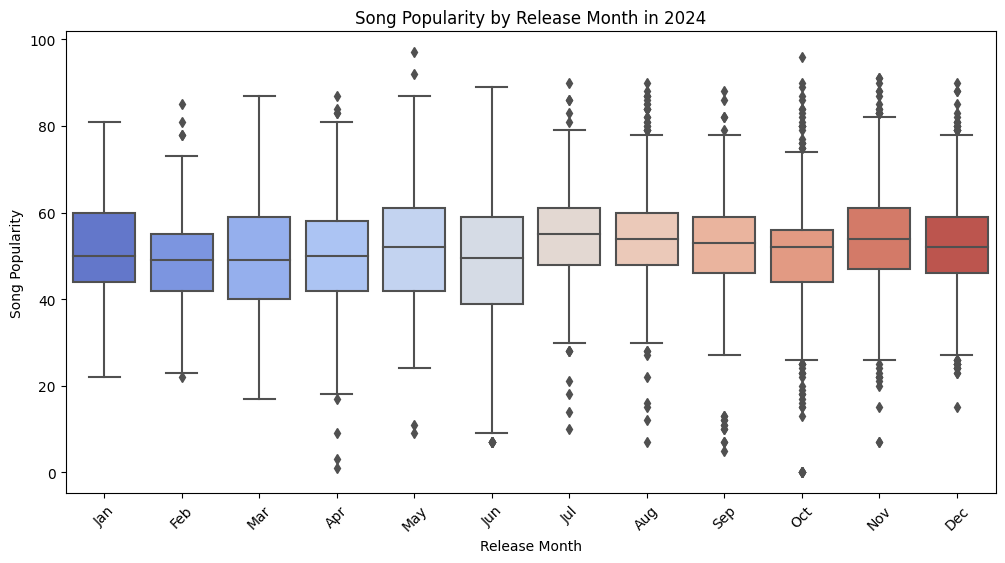

In [34]:
# STEP 3: RELEASE TIMING AND POPULARITY

# Extract release month
df_spotify_data_2024['release_month'] = pd.to_datetime(df_spotify_data_2024['album_release_date']).dt.month

# Boxplot for popularity by release month
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='release_month',
    y='song_popularity',
    data=df_spotify_data_2024,
    palette="coolwarm"
)
plt.title('Song Popularity by Release Month in 2024')
plt.xlabel('Release Month')
plt.ylabel('Song Popularity')
plt.xticks(range(0, 12), [
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
], rotation=45)
plt.show()

### 3.2. Trends in Album Popularity and Influencing Factors  <a id="item-nine"></a>

**Question** = How do factors like the number of featurings and number of tracks impact album popularity for 2024 releases?

In [35]:
# STEP 1: EXPLORE THE DATA

# Summary statistics
popularity_summary = df_spotify_data_2024_album_level[['album_popularity', 'album_total_tracks', 'album_number_featuring']].describe()
print("Summary Statistics:\n", popularity_summary)

# Check for missing values
missing_values = df_spotify_data_2024_album_level[['album_popularity', 'album_total_tracks', 'album_number_featuring']].isnull().sum()
print("\nMissing Values:\n", missing_values)

# Change 'album_release_date' to datetime and check the data types of the other columns
df_spotify_data_2024_album_level['album_release_date'] = pd.to_datetime(df_spotify_data_2024_album_level['album_release_date'])
print("\nData Types:\n")
df_spotify_data_2024.info()

Summary Statistics:
        album_popularity  album_total_tracks  album_number_featuring
count        443.000000          443.000000              443.000000
mean          66.279910           15.769752                4.200903
std            8.005837            9.143714                6.141455
min           44.000000            7.000000                0.000000
25%           61.000000           10.000000                0.000000
50%           65.000000           14.000000                2.000000
75%           71.000000           18.000000                6.000000
max           93.000000          113.000000               50.000000

Missing Values:
 album_popularity          0
album_total_tracks        0
album_number_featuring    0
dtype: int64

Data Types:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6903 entries, 0 to 6934
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   song_i

Text(0, 0.5, 'Frequency')

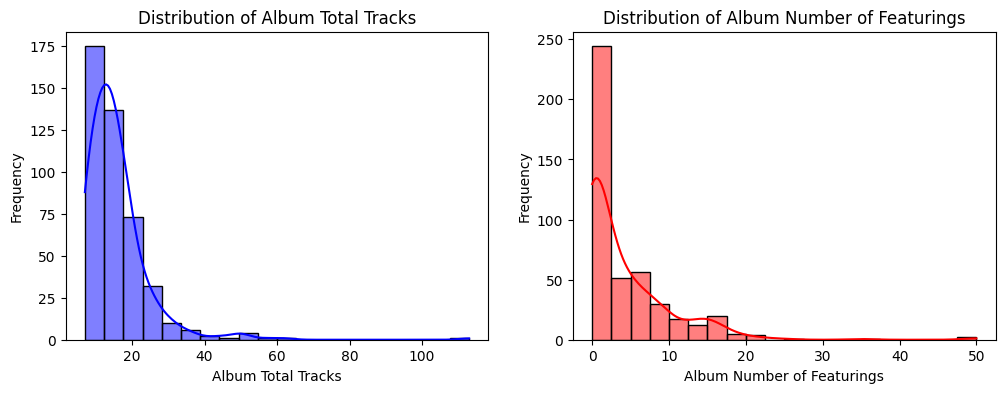

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

In [37]:
# STEP 2: TRENDS IN ALBUM TOTAL TRACKS AND ALBUM NUMBER OF FEATURINGS

fig, axes = plt.subplots(1, 2, figsize=(12,4))

# PART A: "DISTRIBUTION OF ALBUM TOTAL TRACKS"
plt.figure(figsize=(6, 3))
sns.histplot(df_spotify_data_2024_album_level['album_total_tracks'], bins=20, kde=True, color='blue', ax=axes[0])
axes[0].set_title('Distribution of Album Total Tracks')
axes[0].set_xlabel('Album Total Tracks')
axes[0].set_ylabel('Frequency')

# PART B: "DISTRIBUTION OF ALBUM NUMBER OF FEATURINGS"
plt.figure(figsize=(6, 3))
sns.histplot(df_spotify_data_2024_album_level['album_number_featuring'], bins=20, kde=True, color='red', ax=axes[1])
axes[1].set_title('Distribution of Album Number of Featurings')
axes[1].set_xlabel('Album Number of Featurings')
axes[1].set_ylabel('Frequency')

Text(37.5, 80.45, 'Correlation: 0.10')

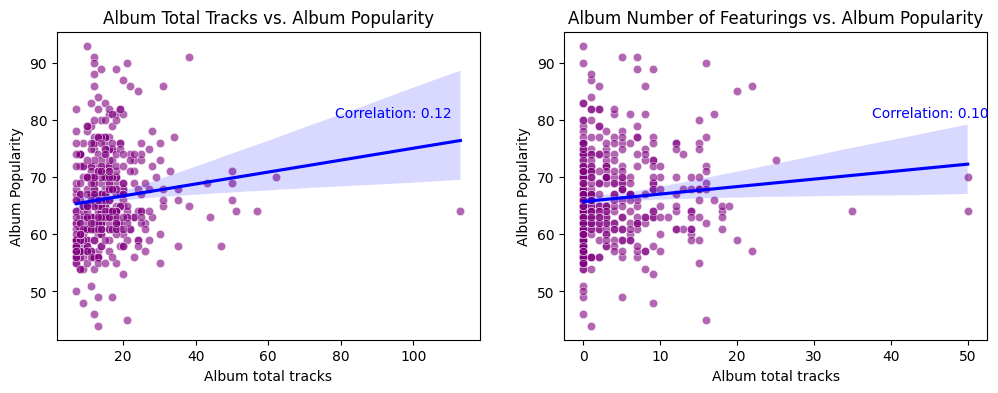

In [38]:
# STEP 3: "ALBUM TOTAL TRACKS VS POPULARITY" AND "ALBUM NUMBER OF FEATURINGS VS POPULARITY"

# PART A: "ALBUM TOTAL TRACKS VS POPULARITY"
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.scatterplot(
    x=df_spotify_data_2024_album_level['album_total_tracks'],
    y=df_spotify_data_2024_album_level['album_popularity'],
    alpha=0.6, color='purple', ax=axes[0]
)
sns.regplot(
    x=df_spotify_data_2024_album_level['album_total_tracks'],
    y=df_spotify_data_2024_album_level['album_popularity'],
    scatter=False,
    color='blue', ax=axes[0]
)

correlation = (df_spotify_data_2024_album_level['album_total_tracks']).corr(df_spotify_data_2024_album_level['album_popularity'])

axes[0].set_title('Album Total Tracks vs. Album Popularity')
axes[0].set_xlabel('Album total tracks')
axes[0].set_ylabel('Album Popularity')
axes[0].text(x=axes[0].get_xlim()[1] - 40,
         y=axes[0].get_ylim()[1] - 15,
         s=f'Correlation: {correlation:.2f}',
         fontsize=10, 
         color='blue')

# PART B: "ALBUM NUMBER OF FEATURINGS VS POPULARITY"
sns.scatterplot(
    x=df_spotify_data_2024_album_level['album_number_featuring'], 
    y=df_spotify_data_2024_album_level['album_popularity'],
    alpha=0.6, color='purple', ax=axes[1]
)
sns.regplot(
    x=df_spotify_data_2024_album_level['album_number_featuring'],
    y=df_spotify_data_2024_album_level['album_popularity'],
    scatter=False,
    color='blue', ax=axes[1]
)

correlation = (df_spotify_data_2024_album_level['album_number_featuring']).corr(df_spotify_data_2024_album_level['album_popularity'])

axes[1].set_title('Album Number of Featurings vs. Album Popularity')
axes[1].set_xlabel('Album total tracks')
axes[1].set_ylabel('Album Popularity')
axes[1].text(x=axes[1].get_xlim()[1] - 15,
         y=axes[1].get_ylim()[1] - 15,
         s=f'Correlation: {correlation:.2f}',
         fontsize=10, 
         color='blue')

---
## 4. Statistical Analysis of Album Popularity &#x1F680; <a id="item-ten"></a>

### 4.1. Comparison of Albums with Track Count Above vs Below Median <a id="item-eleven"></a>

**Question** = Is there a significant difference in the average popularity of albums with a track count above the median compared to those with a track count below or equal to the median?

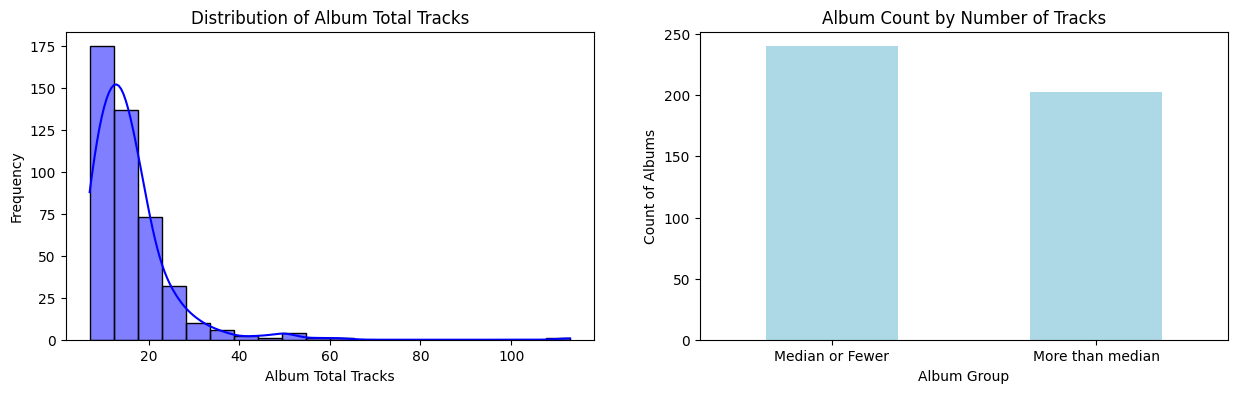

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

# PART A: "DISTRIBUTION OF ALBUM TOTAL TRACKS"
plt.figure(figsize=(6, 3))
sns.histplot(df_spotify_data_2024_album_level['album_total_tracks'], bins=20, kde=True, color='blue', ax=axes[0])
axes[0].set_title('Distribution of Album Total Tracks')
axes[0].set_xlabel('Album Total Tracks')
axes[0].set_ylabel('Frequency')

# PART B: "ALBUM COUNT BY NUMBER OF TRACKS"
album_count = df_spotify_data_2024_album_level['album_total_tracks'].apply(lambda x: 'More than median' 
                                                                           if x > df_spotify_data_2024_album_level['album_total_tracks'].median() 
                                                                           else 'Median or Fewer').value_counts()
plt.figure(figsize=(6, 3))
album_count.plot(kind='bar', color='lightblue', ax=axes[1])
axes[1].set_title('Album Count by Number of Tracks')
axes[1].set_xlabel('Album Group')
axes[1].set_ylabel('Count of Albums')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [42]:
# Split data based on album's track count (greater than median and median or fewer)
albums_more_than_median_tracks = df_spotify_data_2024_album_level[df_spotify_data_2024_album_level['album_total_tracks'] > 
                                                              df_spotify_data_2024_album_level['album_total_tracks'].median()]
albums_median_or_fewer_tracks = df_spotify_data_2024_album_level[df_spotify_data_2024_album_level['album_total_tracks'] <= 
                                                             df_spotify_data_2024_album_level['album_total_tracks'].median()]

# Perform one-sided t-test (testing if albums with tracks more than the median have higher popularity)
t_stat, p_value = stats.ttest_ind(albums_more_than_median_tracks['album_popularity'],albums_median_or_fewer_tracks['album_popularity'], alternative='greater')

print(f"T-statistic: {t_stat}\n\nP-value: {p_value}")

T-statistic: 3.898555607587316

P-value: 5.591127545194226e-05


### 4.2. Comparison of Albums with Featurings Above vs Below Median <a id="item-twelve"></a>

**Question** = Is there a significant difference in the average popularity of albums with more featuring songs than the median compared to albums with fewer featuring songs than the median?

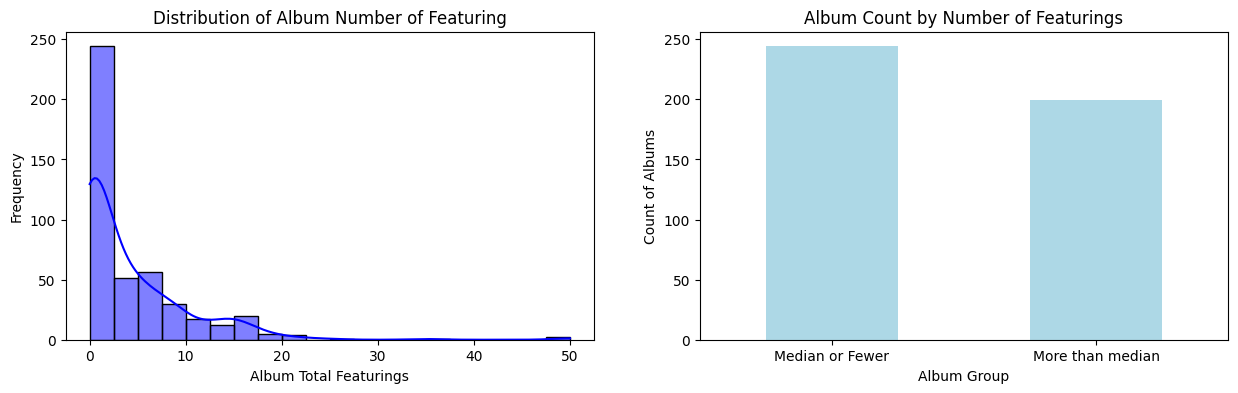

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

# PART A: "DISTRIBUTION OF ALBUM NUMBER OF FEATURINGS"
plt.figure(figsize=(6, 3))
sns.histplot(df_spotify_data_2024_album_level['album_number_featuring'], bins=20, kde=True, color='blue', ax=axes[0])
axes[0].set_title('Distribution of Album Number of Featuring')
axes[0].set_xlabel('Album Total Featurings')
axes[0].set_ylabel('Frequency')

# PART B: "ALBUM COUNT BY NUMBER OF FEATURINGS"
album_count = df_spotify_data_2024_album_level['album_number_featuring'].apply(lambda x: 'More than median' 
                                                                           if x > df_spotify_data_2024_album_level['album_number_featuring'].median() 
                                                                           else 'Median or Fewer').value_counts()
plt.figure(figsize=(6, 3))
album_count.plot(kind='bar', color='lightblue', ax=axes[1])
axes[1].set_title('Album Count by Number of Featurings')
axes[1].set_xlabel('Album Group')
axes[1].set_ylabel('Count of Albums')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [45]:
# Split data based on album's featurings count (greater than median and median or fewer)
albums_more_than_median_featurings = df_spotify_data_2024_album_level[df_spotify_data_2024_album_level['album_number_featuring'] > 
                                                              df_spotify_data_2024_album_level['album_number_featuring'].median()]
albums_median_or_fewer_featurings = df_spotify_data_2024_album_level[df_spotify_data_2024_album_level['album_number_featuring'] <= 
                                                             df_spotify_data_2024_album_level['album_number_featuring'].median()]

# Perform one-sided t-test (testing if albums featurings with more than the median have higher popularity)
t_stat, p_value = stats.ttest_ind(albums_more_than_median_featurings['album_popularity'], albums_median_or_fewer_featurings['album_popularity'], 
                                  alternative='greater')

print(f"T-statistic: {t_stat}\n\nP-value: {p_value}")

T-statistic: 2.57297429932385

P-value: 0.005204392338995616


### 4.3. Comparison of Albums with Time Since Release Above vs Below 4 Months <a id="item-twelve2"></a>

**Question** = Is there a significant difference in the average popularity of albums released more than 4 months ago compared to those released 4 months ago or less?

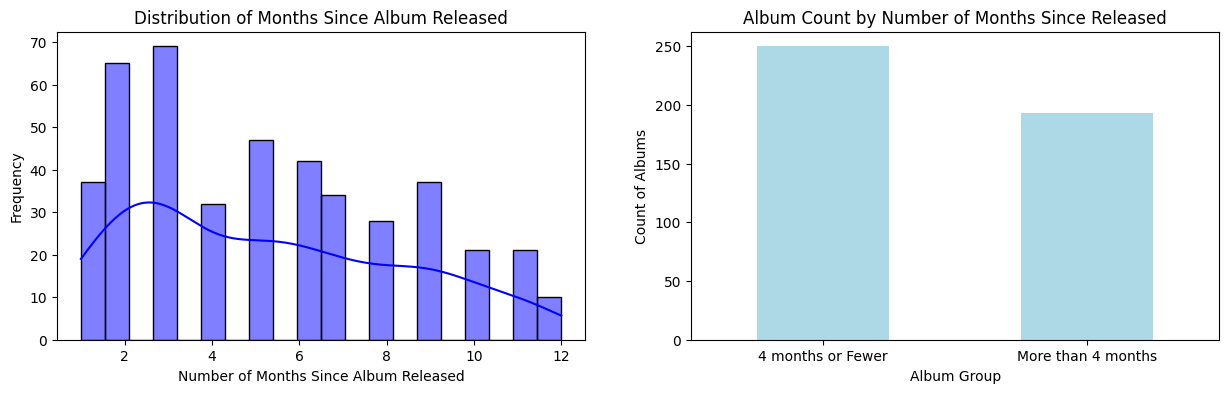

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

In [52]:
current_date = pd.Timestamp("2025-01-22") # In my case the date I am putting there would my -> pd.Timestamp.now(). You can use now() to see how the value changes.
df_spotify_data_2024_album_level['album_time_since_released'] = (
    (current_date.year - df_spotify_data_2024_album_level['album_release_date'].dt.year) * 12 +
    (current_date.month - df_spotify_data_2024_album_level['album_release_date'].dt.month)
)

fig, axes = plt.subplots(1, 2, figsize=(15,4))

# PART A: "DISTRIBUTION OF MONTHS SINCE ALBUM RELEASED"
plt.figure(figsize=(6, 3))
sns.histplot(df_spotify_data_2024_album_level['album_time_since_released'], bins=20, kde=True, color='blue', ax=axes[0])
axes[0].set_title('Distribution of Months Since Album Released')
axes[0].set_xlabel('Number of Months Since Album Released')
axes[0].set_ylabel('Frequency')

# PART B: "ALBUM COUNT BY NUMBER OF MONTHS SINCE RELEASED"
album_count = df_spotify_data_2024_album_level['album_time_since_released'].apply(lambda x: 'More than 4 months' 
                                                                           if x > df_spotify_data_2024_album_level['album_time_since_released'].median() 
                                                                           else '4 months or Fewer').value_counts()
plt.figure(figsize=(6, 3))
album_count.plot(kind='bar', color='lightblue', ax=axes[1])
axes[1].set_title('Album Count by Number of Months Since Released')
axes[1].set_xlabel('Album Group')
axes[1].set_ylabel('Count of Albums')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [53]:
# Split data based on album's number of months since released (greater than 4 months and 4 months or fewer)
albums_more_than_4m_sr = df_spotify_data_2024_album_level[df_spotify_data_2024_album_level['album_time_since_released'] > 4]
albums_4m_sr_or_fewer = df_spotify_data_2024_album_level[df_spotify_data_2024_album_level['album_time_since_released'] <= 4]

# Perform one-sided t-test (testing if the albums with more than 4 months since released have higher popularity)
t_stat, p_value = stats.ttest_ind(albums_more_than_4m_sr['album_popularity'],albums_4m_sr_or_fewer['album_popularity'], alternative='greater')

print(f"T-statistic: {t_stat}\n\nP-value: {p_value}")

T-statistic: 1.5367326103072814

P-value: 0.06253796773185108


---
## 5. Correlation Between Artist Followers and Album Popularity &#x1F680; <a id="item-thirteen"></a>

**Question** = How does the number of artist followers correlate with the popularity of their albums?

Correlation between artist followers and album popularity: 0.33635814379421924


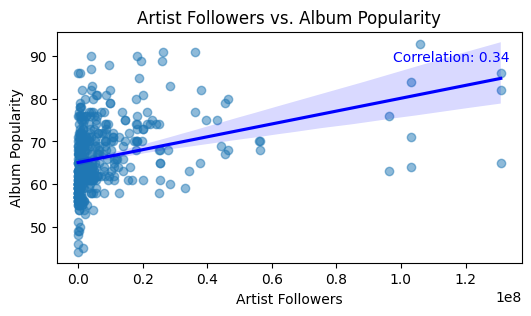

In [106]:
correlation_followers_popularity = df_spotify_data_2024_album_level['album_artist_followers'].corr(df_spotify_data_2024_album_level['album_popularity'])
print(f"Correlation between artist followers and album popularity: {correlation_followers_popularity}")

# Scatter plot with regression line
plt.figure(figsize=(6, 3))
sns.regplot(x='album_artist_followers', y='album_popularity', data=df_spotify_data_2024_album_level, scatter_kws={'alpha':0.5}, line_kws={'color':'blue'})
plt.title('Artist Followers vs. Album Popularity')
plt.xlabel('Artist Followers')
plt.ylabel('Album Popularity')
plt.text(x=plt.gca().get_xlim()[1] - 40000000,
         y=plt.gca().get_ylim()[1] - 7,
         s=f'Correlation: {correlation_followers_popularity:.2f}',
         color='blue')
plt.show()

---
## 6. Genre-Based Correlation Analysis: Artist Followers, Total Tracks, and Album Popularity with Respect to Album Popularity &#x1F680; <a id="item-fourteen"></a>

### 6.1. Most Common Genres in 2024 Albums <a id="item-fifteen"></a>

In [246]:
# Calculating the number of times a specific genre appear on an album
df_exploded = df_spotify_data_2024_album_level.copy().explode('album_artist_genres')
df_exploded['count_flag'] = 1
df_exploded2 = df_exploded.groupby('album_artist_genres')[['count_flag']].sum().sort_values(by='count_flag', ascending=False).reset_index()
df_exploded2.head(5)

,album_artist_genres,count_flag
0,country,32
1,k-pop,29
2,pop urbaine,20
3,afrobeats,18
4,punjabi hip hop,16


### 6.2. Correlations in Top 5 Most Common Genres <a id="item-sixteen"></a>

32
Correlation between artist followers and album popularity: 0.16691436353756023
Correlation between artist followers and album popularity: 0.06880889738475417
Correlation between artist followers and album popularity: 0.016174197489186276


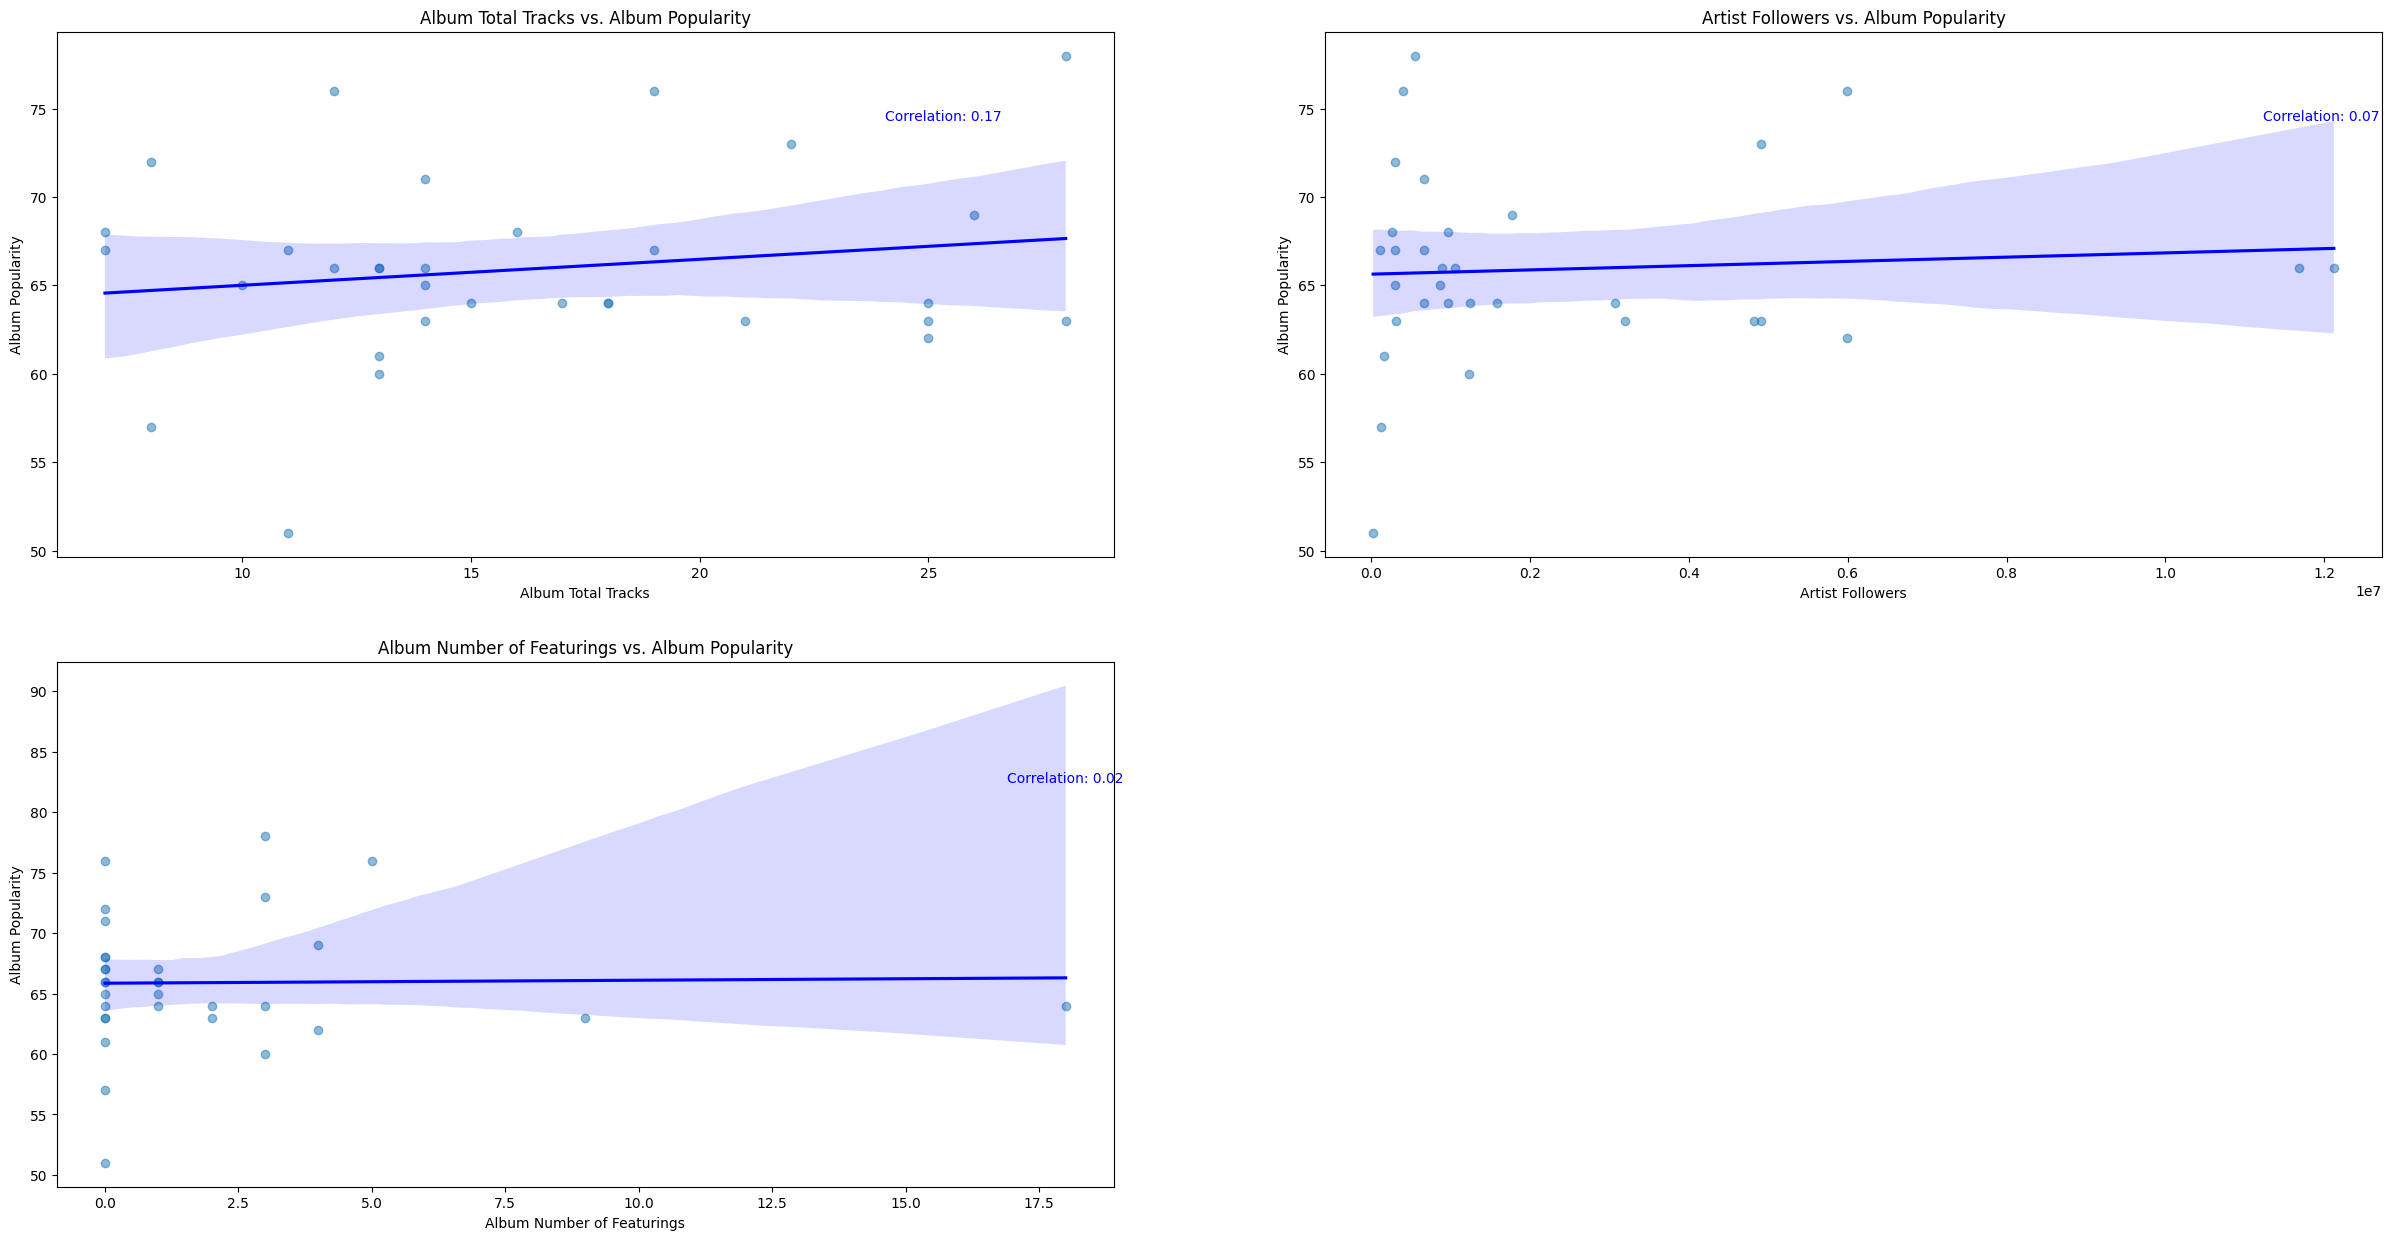

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

In [329]:
fig, axes = plt.subplots(2, 2, figsize=(30,15))

df_example = df_spotify_data_2024_album_level[df_spotify_data_2024_album_level['album_artist_genres'].astype(str).str.contains('country|red dirt', na=False)]
print(len(df_example))

# PART A
correlation_followers_popularity = df_example['album_total_tracks'].corr(df_example['album_popularity'])
print(f"Correlation between artist followers and album popularity: {correlation_followers_popularity}")

# Scatter plot with regression line
plt.figure(figsize=(6, 3))
sns.regplot(x='album_total_tracks', y='album_popularity', data=df_example, scatter_kws={'alpha':0.5}, line_kws={'color':'blue'}, ax=axes[0,0])
axes[0,0].set_title('Album Total Tracks vs. Album Popularity')
axes[0,0].set_xlabel('Album Total Tracks')
axes[0,0].set_ylabel('Album Popularity')
axes[0,0].text(x=axes[0,0].get_xlim()[1] - 5,
         y=axes[0,0].get_ylim()[1] - 5,
         s=f'Correlation: {correlation_followers_popularity:.2f}',
         color='blue')

# PART B
correlation_followers_popularity = df_example['album_artist_followers'].corr(df_example['album_popularity'])
print(f"Correlation between artist followers and album popularity: {correlation_followers_popularity}")

# Scatter plot with regression line
plt.figure(figsize=(6, 3))
sns.regplot(x='album_artist_followers', y='album_popularity', data=df_example, scatter_kws={'alpha':0.5}, line_kws={'color':'blue'}, ax=axes[0,1])
axes[0,1].set_title('Artist Followers vs. Album Popularity')
axes[0,1].set_xlabel('Artist Followers')
axes[0,1].set_ylabel('Album Popularity')
axes[0,1].text(x=axes[0,1].get_xlim()[1] - 1500000,
         y=axes[0,1].get_ylim()[1] - 5,
         s=f'Correlation: {correlation_followers_popularity:.2f}',
         color='blue')

# PART C
correlation_followers_popularity = df_example['album_number_featuring'].corr(df_example['album_popularity'])
print(f"Correlation between artist followers and album popularity: {correlation_followers_popularity}")

# Scatter plot with regression line
plt.figure(figsize=(6, 3))
sns.regplot(x='album_number_featuring', y='album_popularity', data=df_example, scatter_kws={'alpha':0.5}, line_kws={'color':'blue'}, ax=axes[1,0])
axes[1,0].set_title('Album Number of Featurings vs. Album Popularity')
axes[1,0].set_xlabel('Album Number of Featurings')
axes[1,0].set_ylabel('Album Popularity')
axes[1,0].text(x=axes[1,0].get_xlim()[1] - 2,
         y=axes[1,0].get_ylim()[1] - 10,
         s=f'Correlation: {correlation_followers_popularity:.2f}',
         color='blue')

axes[1,1].axis('off')

plt.show()

29
Correlation between artist followers and album popularity: -0.017420748409008972
Correlation between artist followers and album popularity: 0.4727718757409916
Correlation between artist followers and album popularity: -0.14826836689788792


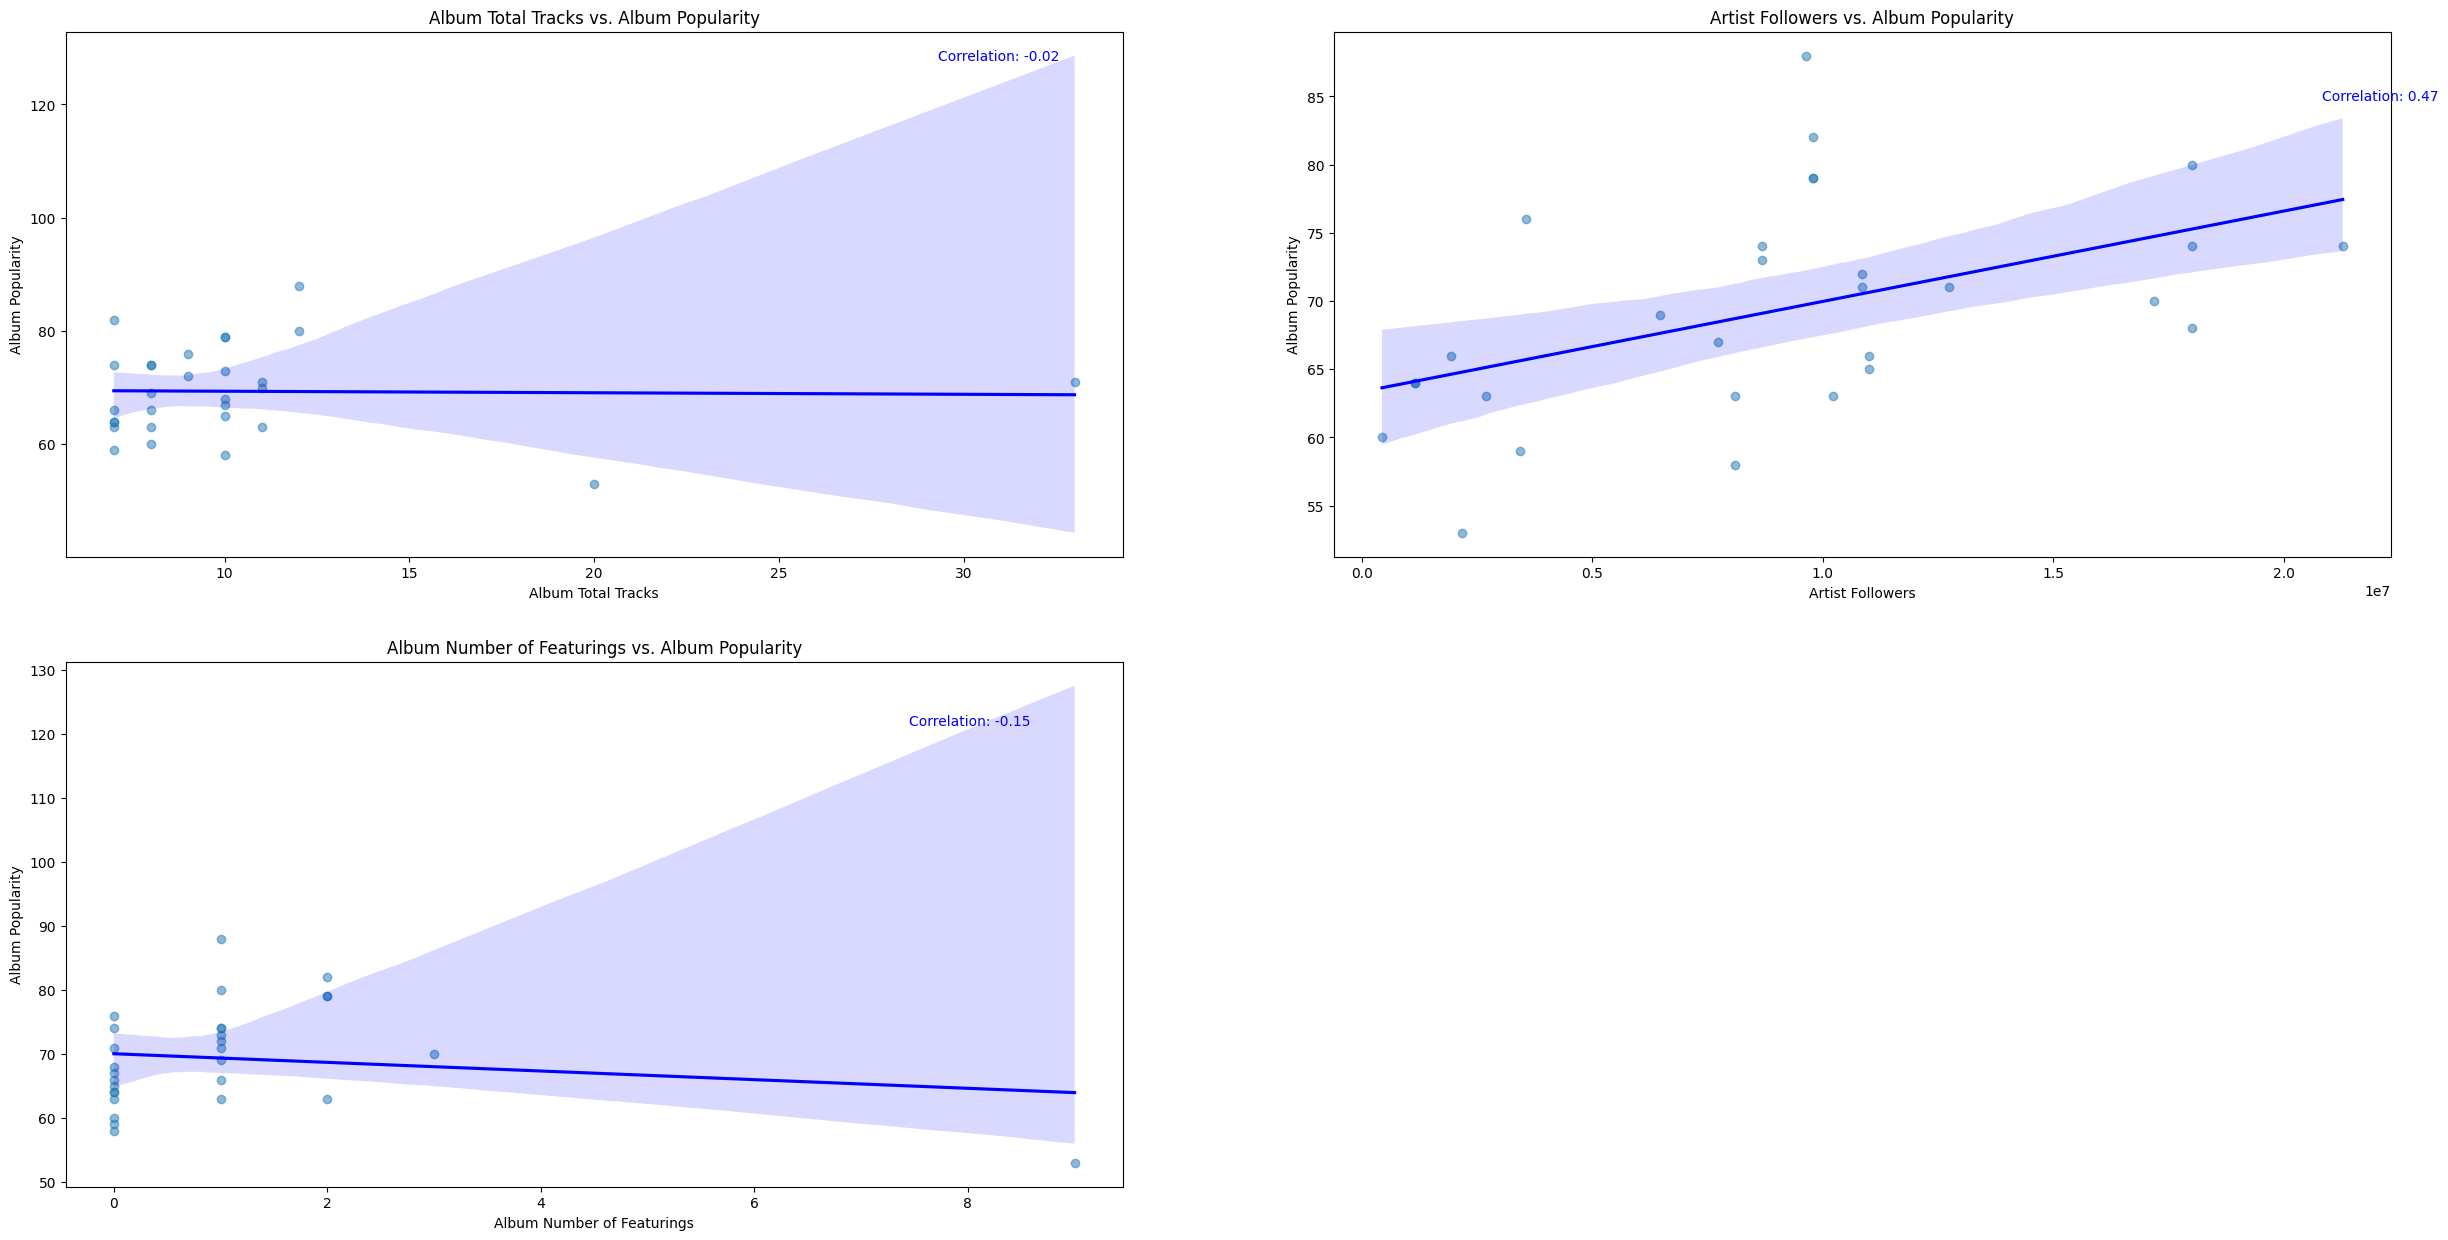

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

In [330]:
fig, axes = plt.subplots(2, 2, figsize=(30,15))

df_example = df_spotify_data_2024_album_level[df_spotify_data_2024_album_level['album_artist_genres'].astype(str).str.contains('k-pop|k-rap', na=False)]
print(len(df_example))

# PART A
correlation_followers_popularity = df_example['album_total_tracks'].corr(df_example['album_popularity'])
print(f"Correlation between artist followers and album popularity: {correlation_followers_popularity}")

# Scatter plot with regression line
plt.figure(figsize=(6, 3))
sns.regplot(x='album_total_tracks', y='album_popularity', data=df_example, scatter_kws={'alpha':0.5}, line_kws={'color':'blue'}, ax=axes[0,0])
axes[0,0].set_title('Album Total Tracks vs. Album Popularity')
axes[0,0].set_xlabel('Album Total Tracks')
axes[0,0].set_ylabel('Album Popularity')
axes[0,0].text(x=axes[0,0].get_xlim()[1] - 5,
         y=axes[0,0].get_ylim()[1] - 5,
         s=f'Correlation: {correlation_followers_popularity:.2f}',
         color='blue')

# PART B
correlation_followers_popularity = df_example['album_artist_followers'].corr(df_example['album_popularity'])
print(f"Correlation between artist followers and album popularity: {correlation_followers_popularity}")

# Scatter plot with regression line
plt.figure(figsize=(6, 3))
sns.regplot(x='album_artist_followers', y='album_popularity', data=df_example, scatter_kws={'alpha':0.5}, line_kws={'color':'blue'}, ax=axes[0,1])
axes[0,1].set_title('Artist Followers vs. Album Popularity')
axes[0,1].set_xlabel('Artist Followers')
axes[0,1].set_ylabel('Album Popularity')
axes[0,1].text(x=axes[0,1].get_xlim()[1] - 1500000,
         y=axes[0,1].get_ylim()[1] - 5,
         s=f'Correlation: {correlation_followers_popularity:.2f}',
         color='blue')

# PART C
correlation_followers_popularity = df_example['album_number_featuring'].corr(df_example['album_popularity'])
print(f"Correlation between artist followers and album popularity: {correlation_followers_popularity}")

# Scatter plot with regression line
plt.figure(figsize=(6, 3))
sns.regplot(x='album_number_featuring', y='album_popularity', data=df_example, scatter_kws={'alpha':0.5}, line_kws={'color':'blue'}, ax=axes[1,0])
axes[1,0].set_title('Album Number of Featurings vs. Album Popularity')
axes[1,0].set_xlabel('Album Number of Featurings')
axes[1,0].set_ylabel('Album Popularity')
axes[1,0].text(x=axes[1,0].get_xlim()[1] - 2,
         y=axes[1,0].get_ylim()[1] - 10,
         s=f'Correlation: {correlation_followers_popularity:.2f}',
         color='blue')

axes[1,1].axis('off')

plt.show()

23
Correlation between artist followers and album popularity: 0.1626011431178162
Correlation between artist followers and album popularity: 0.4031946116886384
Correlation between artist followers and album popularity: 0.2633299480199809


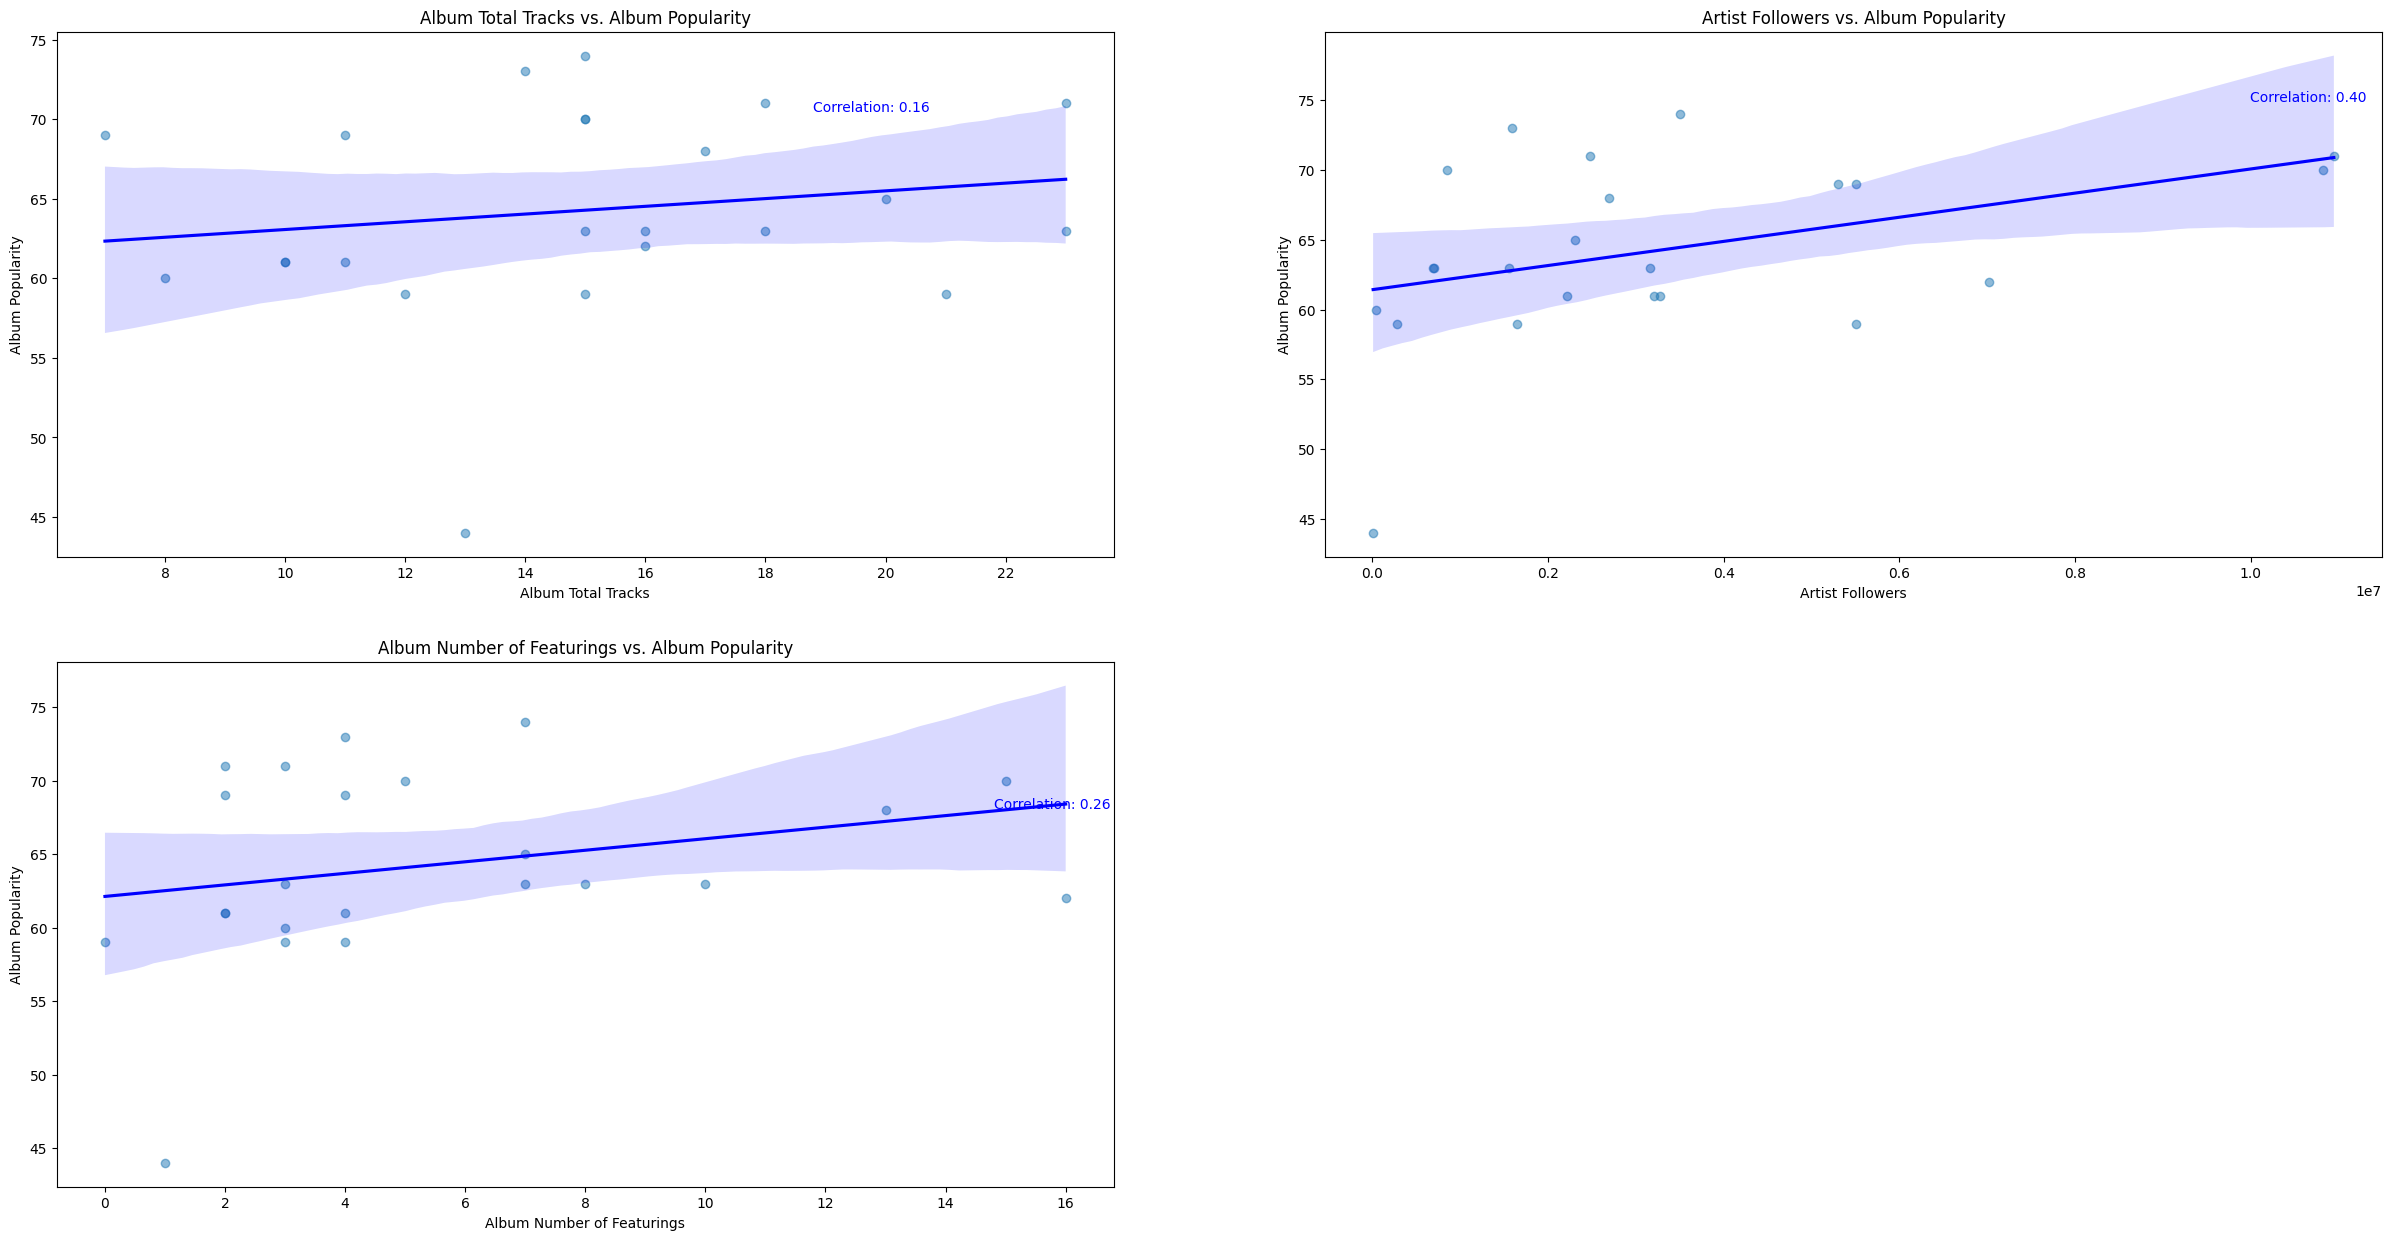

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

In [331]:
fig, axes = plt.subplots(2, 2, figsize=(30,15))

df_example = df_spotify_data_2024_album_level[df_spotify_data_2024_album_level['album_artist_genres'].astype(str).str.contains('pop urbaine|drill', na=False)]
print(len(df_example))

# PART A
correlation_followers_popularity = df_example['album_total_tracks'].corr(df_example['album_popularity'])
print(f"Correlation between artist followers and album popularity: {correlation_followers_popularity}")

# Scatter plot with regression line
plt.figure(figsize=(6, 3))
sns.regplot(x='album_total_tracks', y='album_popularity', data=df_example, scatter_kws={'alpha':0.5}, line_kws={'color':'blue'}, ax=axes[0,0])
axes[0,0].set_title('Album Total Tracks vs. Album Popularity')
axes[0,0].set_xlabel('Album Total Tracks')
axes[0,0].set_ylabel('Album Popularity')
axes[0,0].text(x=axes[0,0].get_xlim()[1] - 5,
         y=axes[0,0].get_ylim()[1] - 5,
         s=f'Correlation: {correlation_followers_popularity:.2f}',
         color='blue')

# PART B
correlation_followers_popularity = df_example['album_artist_followers'].corr(df_example['album_popularity'])
print(f"Correlation between artist followers and album popularity: {correlation_followers_popularity}")

# Scatter plot with regression line
plt.figure(figsize=(6, 3))
sns.regplot(x='album_artist_followers', y='album_popularity', data=df_example, scatter_kws={'alpha':0.5}, line_kws={'color':'blue'}, ax=axes[0,1])
axes[0,1].set_title('Artist Followers vs. Album Popularity')
axes[0,1].set_xlabel('Artist Followers')
axes[0,1].set_ylabel('Album Popularity')
axes[0,1].text(x=axes[0,1].get_xlim()[1] - 1500000,
         y=axes[0,1].get_ylim()[1] - 5,
         s=f'Correlation: {correlation_followers_popularity:.2f}',
         color='blue')

# PART C
correlation_followers_popularity = df_example['album_number_featuring'].corr(df_example['album_popularity'])
print(f"Correlation between artist followers and album popularity: {correlation_followers_popularity}")

# Scatter plot with regression line
plt.figure(figsize=(6, 3))
sns.regplot(x='album_number_featuring', y='album_popularity', data=df_example, scatter_kws={'alpha':0.5}, line_kws={'color':'blue'}, ax=axes[1,0])
axes[1,0].set_title('Album Number of Featurings vs. Album Popularity')
axes[1,0].set_xlabel('Album Number of Featurings')
axes[1,0].set_ylabel('Album Popularity')
axes[1,0].text(x=axes[1,0].get_xlim()[1] - 2,
         y=axes[1,0].get_ylim()[1] - 10,
         s=f'Correlation: {correlation_followers_popularity:.2f}',
         color='blue')

axes[1,1].axis('off')

plt.show()

20
Correlation between artist followers and album popularity: 0.38928506751863334
Correlation between artist followers and album popularity: 0.6622386265044471
Correlation between artist followers and album popularity: 0.059548772157916506


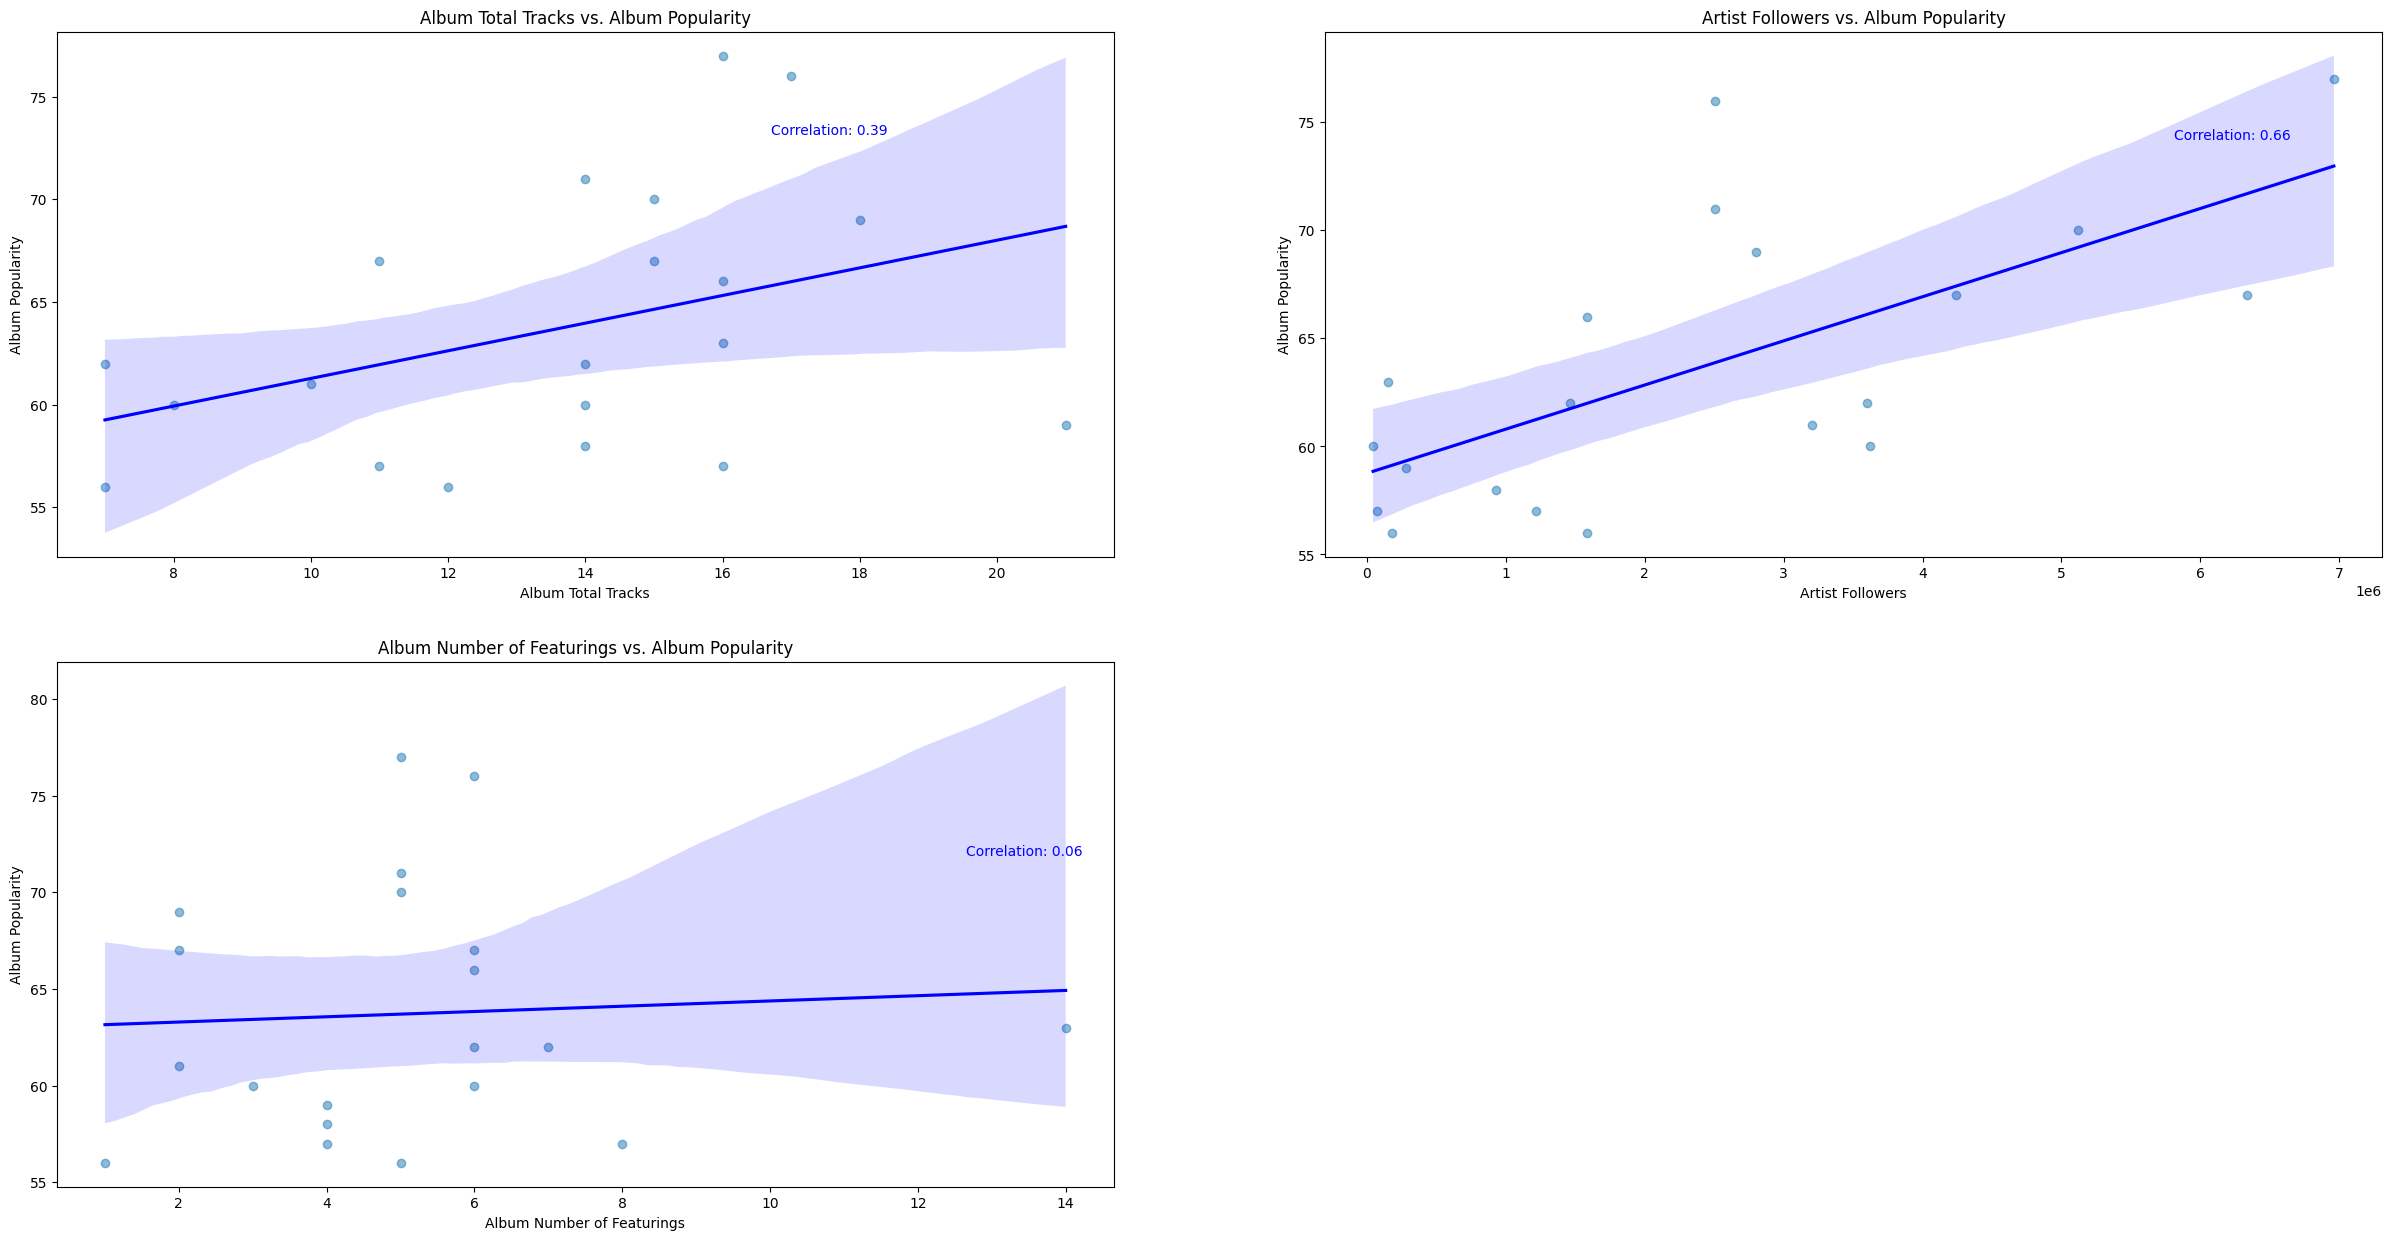

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

In [332]:
fig, axes = plt.subplots(2, 2, figsize=(30,15))

df_example = df_spotify_data_2024_album_level[df_spotify_data_2024_album_level['album_artist_genres'].astype(str).str.contains('dancehall|soca|afro|zouk|alté', na=False)]
print(len(df_example))

# PART A
correlation_followers_popularity = df_example['album_total_tracks'].corr(df_example['album_popularity'])
print(f"Correlation between artist followers and album popularity: {correlation_followers_popularity}")

# Scatter plot with regression line
plt.figure(figsize=(6, 3))
sns.regplot(x='album_total_tracks', y='album_popularity', data=df_example, scatter_kws={'alpha':0.5}, line_kws={'color':'blue'}, ax=axes[0,0])
axes[0,0].set_title('Album Total Tracks vs. Album Popularity')
axes[0,0].set_xlabel('Album Total Tracks')
axes[0,0].set_ylabel('Album Popularity')
axes[0,0].text(x=axes[0,0].get_xlim()[1] - 5,
         y=axes[0,0].get_ylim()[1] - 5,
         s=f'Correlation: {correlation_followers_popularity:.2f}',
         color='blue')

# PART B
correlation_followers_popularity = df_example['album_artist_followers'].corr(df_example['album_popularity'])
print(f"Correlation between artist followers and album popularity: {correlation_followers_popularity}")

# Scatter plot with regression line
plt.figure(figsize=(6, 3))
sns.regplot(x='album_artist_followers', y='album_popularity', data=df_example, scatter_kws={'alpha':0.5}, line_kws={'color':'blue'}, ax=axes[0,1])
axes[0,1].set_title('Artist Followers vs. Album Popularity')
axes[0,1].set_xlabel('Artist Followers')
axes[0,1].set_ylabel('Album Popularity')
axes[0,1].text(x=axes[0,1].get_xlim()[1] - 1500000,
         y=axes[0,1].get_ylim()[1] - 5,
         s=f'Correlation: {correlation_followers_popularity:.2f}',
         color='blue')

# PART C
correlation_followers_popularity = df_example['album_number_featuring'].corr(df_example['album_popularity'])
print(f"Correlation between artist followers and album popularity: {correlation_followers_popularity}")

# Scatter plot with regression line
plt.figure(figsize=(6, 3))
sns.regplot(x='album_number_featuring', y='album_popularity', data=df_example, scatter_kws={'alpha':0.5}, line_kws={'color':'blue'}, ax=axes[1,0])
axes[1,0].set_title('Album Number of Featurings vs. Album Popularity')
axes[1,0].set_xlabel('Album Number of Featurings')
axes[1,0].set_ylabel('Album Popularity')
axes[1,0].text(x=axes[1,0].get_xlim()[1] - 2,
         y=axes[1,0].get_ylim()[1] - 10,
         s=f'Correlation: {correlation_followers_popularity:.2f}',
         color='blue')

axes[1,1].axis('off')

plt.show()

19
Correlation between artist followers and album popularity: 0.7959641173504575
Correlation between artist followers and album popularity: 0.557886270029136
Correlation between artist followers and album popularity: 0.4448343144271938


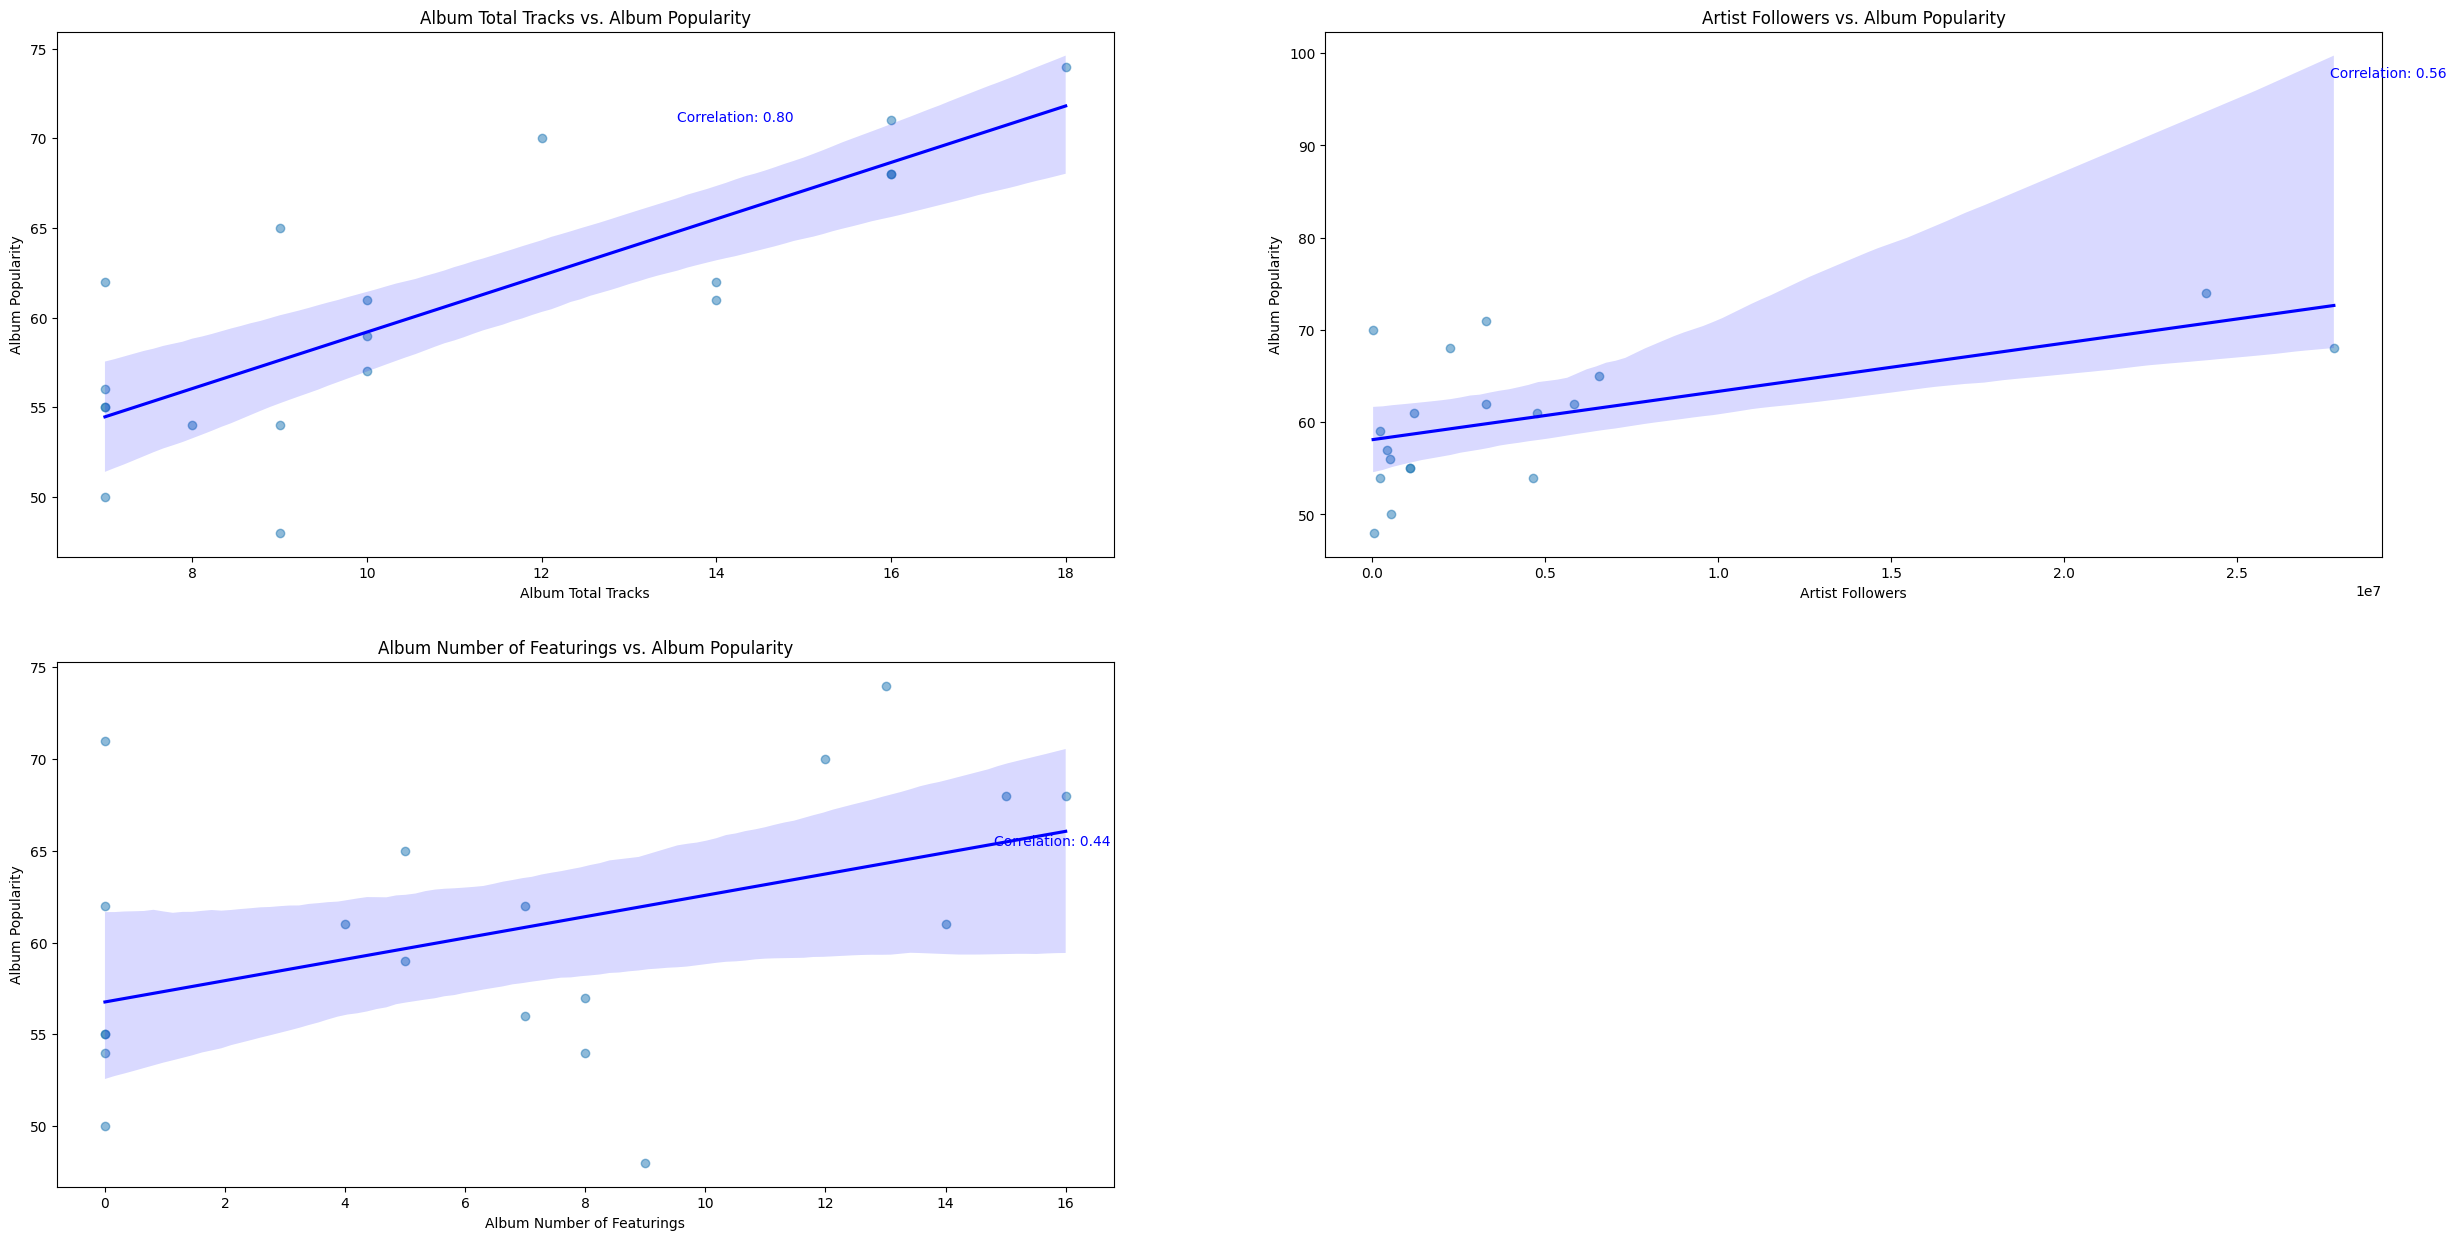

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

In [333]:
fig, axes = plt.subplots(2, 2, figsize=(30,15))

df_example = df_spotify_data_2024_album_level[df_spotify_data_2024_album_level['album_artist_genres'].astype(str).str.contains('punjabi|hindi|bhangra|desi', na=False)]
print(len(df_example))

# PART A
correlation_followers_popularity = df_example['album_total_tracks'].corr(df_example['album_popularity'])
print(f"Correlation between artist followers and album popularity: {correlation_followers_popularity}")

# Scatter plot with regression line
plt.figure(figsize=(6, 3))
sns.regplot(x='album_total_tracks', y='album_popularity', data=df_example, scatter_kws={'alpha':0.5}, line_kws={'color':'blue'}, ax=axes[0,0])
axes[0,0].set_title('Album Total Tracks vs. Album Popularity')
axes[0,0].set_xlabel('Album Total Tracks')
axes[0,0].set_ylabel('Album Popularity')
axes[0,0].text(x=axes[0,0].get_xlim()[1] - 5,
         y=axes[0,0].get_ylim()[1] - 5,
         s=f'Correlation: {correlation_followers_popularity:.2f}',
         color='blue')

# PART B
correlation_followers_popularity = df_example['album_artist_followers'].corr(df_example['album_popularity'])
print(f"Correlation between artist followers and album popularity: {correlation_followers_popularity}")

# Scatter plot with regression line
plt.figure(figsize=(6, 3))
sns.regplot(x='album_artist_followers', y='album_popularity', data=df_example, scatter_kws={'alpha':0.5}, line_kws={'color':'blue'}, ax=axes[0,1])
axes[0,1].set_title('Artist Followers vs. Album Popularity')
axes[0,1].set_xlabel('Artist Followers')
axes[0,1].set_ylabel('Album Popularity')
axes[0,1].text(x=axes[0,1].get_xlim()[1] - 1500000,
         y=axes[0,1].get_ylim()[1] - 5,
         s=f'Correlation: {correlation_followers_popularity:.2f}',
         color='blue')

# PART C
correlation_followers_popularity = df_example['album_number_featuring'].corr(df_example['album_popularity'])
print(f"Correlation between artist followers and album popularity: {correlation_followers_popularity}")

# Scatter plot with regression line
plt.figure(figsize=(6, 3))
sns.regplot(x='album_number_featuring', y='album_popularity', data=df_example, scatter_kws={'alpha':0.5}, line_kws={'color':'blue'}, ax=axes[1,0])
axes[1,0].set_title('Album Number of Featurings vs. Album Popularity')
axes[1,0].set_xlabel('Album Number of Featurings')
axes[1,0].set_ylabel('Album Popularity')
axes[1,0].text(x=axes[1,0].get_xlim()[1] - 2,
         y=axes[1,0].get_ylim()[1] - 10,
         s=f'Correlation: {correlation_followers_popularity:.2f}',
         color='blue')

axes[1,1].axis('off')

plt.show()

### 6.3. Correlations in Personal Favorite Genres <a id="item-seventeen"></a>

8
Correlation between artist followers and album popularity: -0.011352885628759364
Correlation between artist followers and album popularity: 0.7266865945377773
Correlation between artist followers and album popularity: 0.26220018890073743


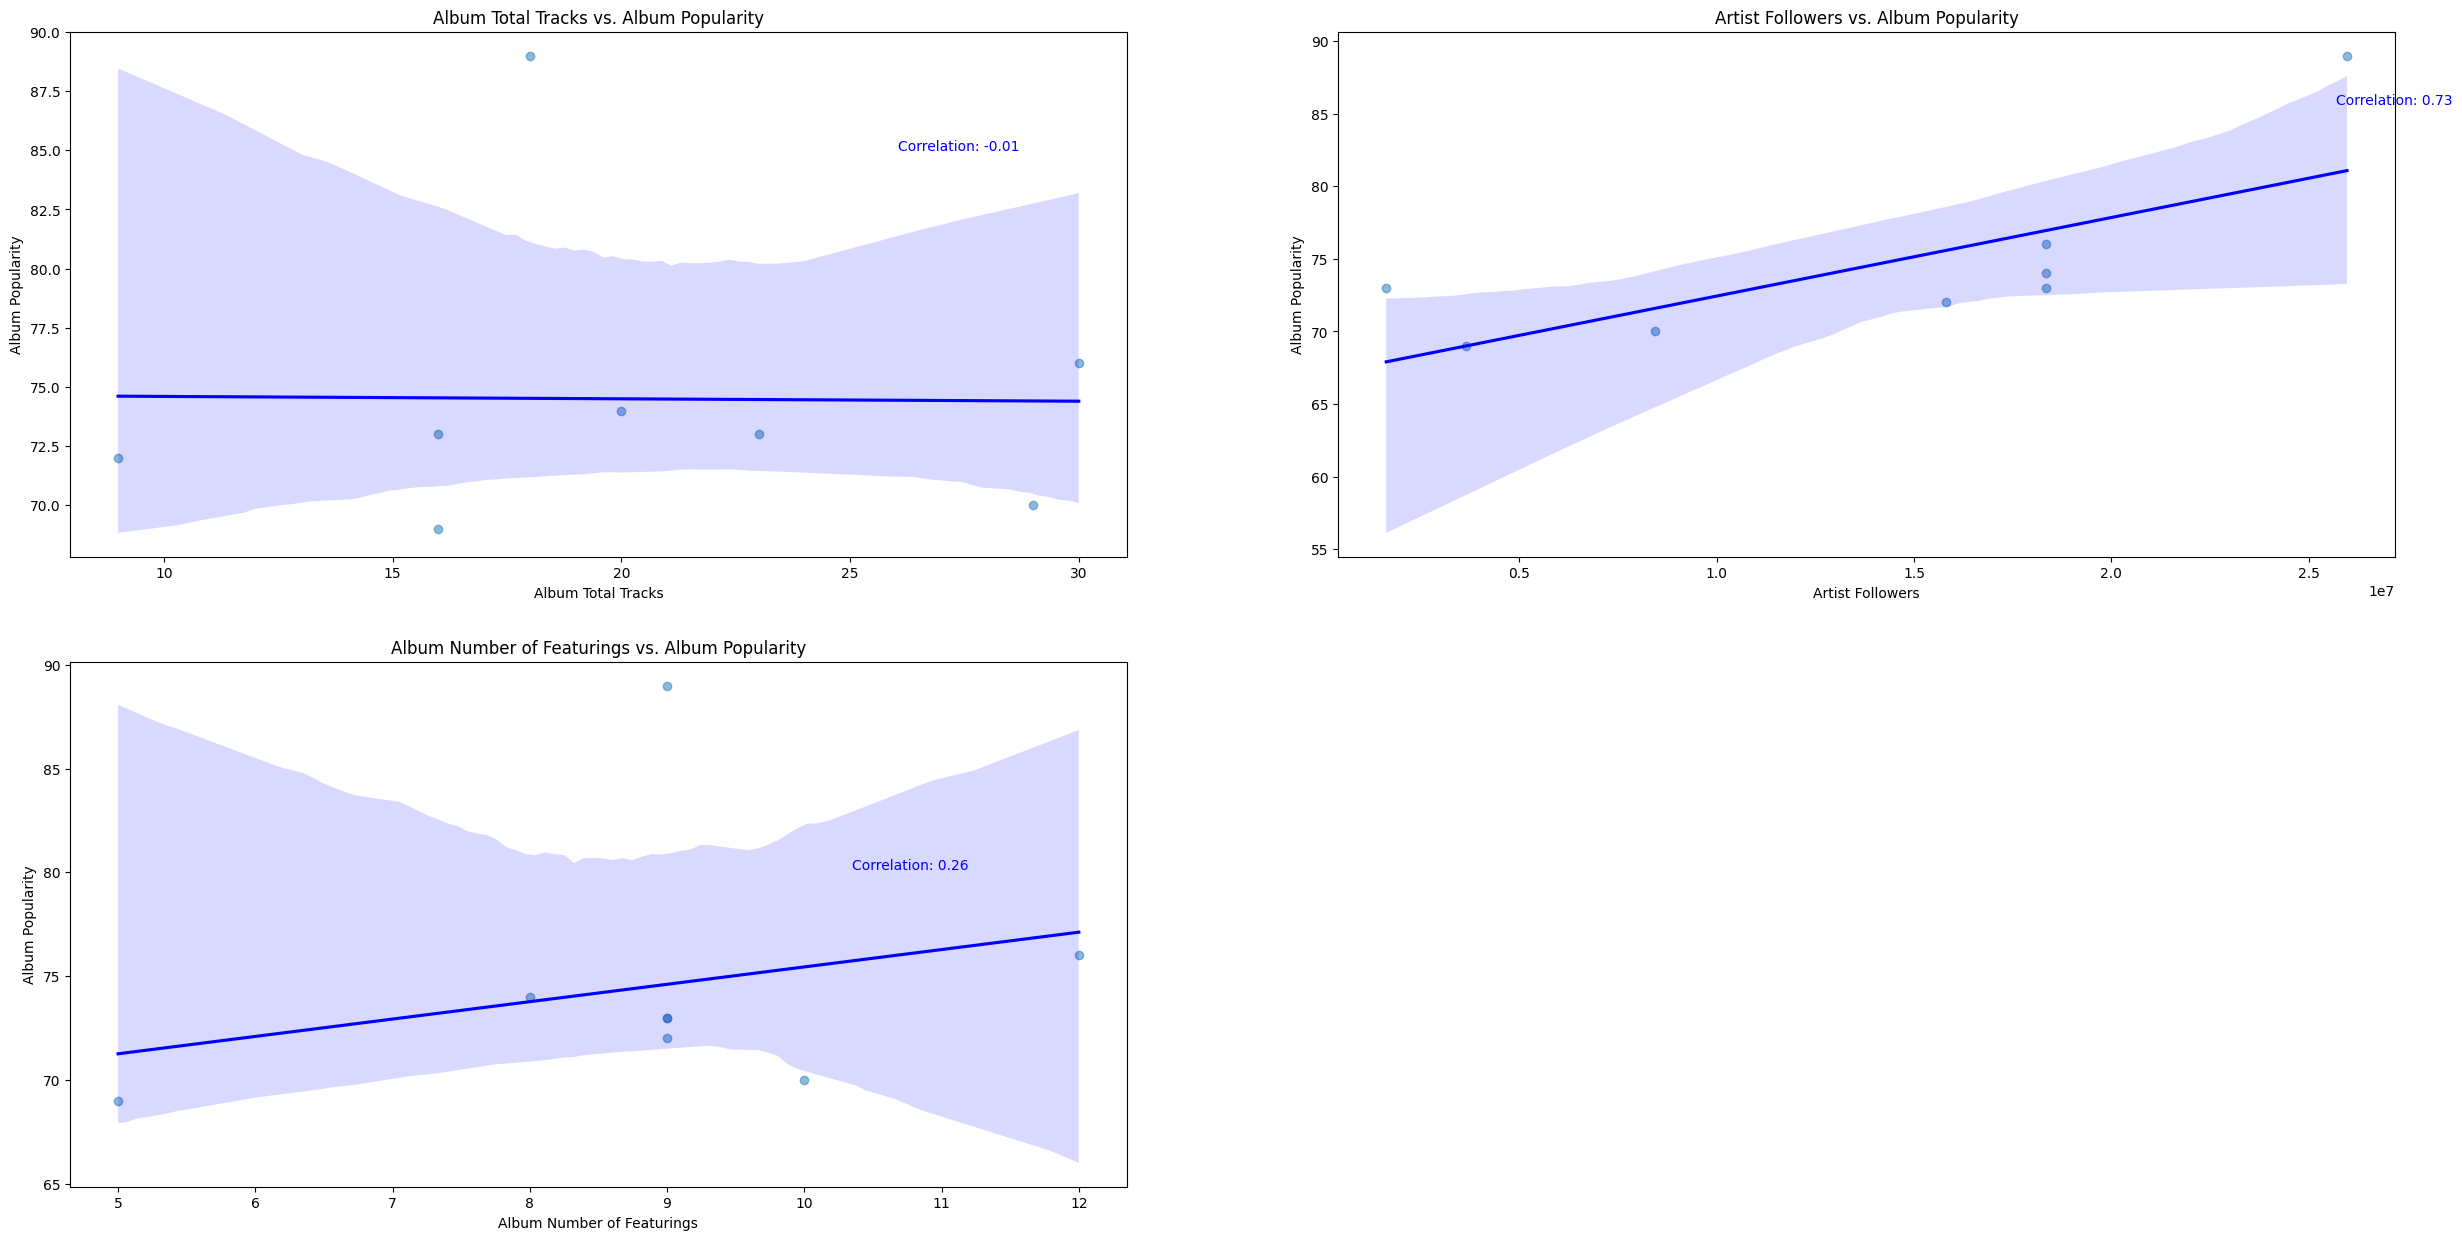

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

In [334]:
fig, axes = plt.subplots(2, 2, figsize=(30,15))

df_example = df_spotify_data_2024_album_level[df_spotify_data_2024_album_level['album_artist_genres'].astype(str).str.contains('trap latino|urbano latino', na=False)]
print(len(df_example))

# PART A
correlation_followers_popularity = df_example['album_total_tracks'].corr(df_example['album_popularity'])
print(f"Correlation between artist followers and album popularity: {correlation_followers_popularity}")

# Scatter plot with regression line
plt.figure(figsize=(6, 3))
sns.regplot(x='album_total_tracks', y='album_popularity', data=df_example, scatter_kws={'alpha':0.5}, line_kws={'color':'blue'}, ax=axes[0,0])
axes[0,0].set_title('Album Total Tracks vs. Album Popularity')
axes[0,0].set_xlabel('Album Total Tracks')
axes[0,0].set_ylabel('Album Popularity')
axes[0,0].text(x=axes[0,0].get_xlim()[1] - 5,
         y=axes[0,0].get_ylim()[1] - 5,
         s=f'Correlation: {correlation_followers_popularity:.2f}',
         color='blue')

# PART B
correlation_followers_popularity = df_example['album_artist_followers'].corr(df_example['album_popularity'])
print(f"Correlation between artist followers and album popularity: {correlation_followers_popularity}")

# Scatter plot with regression line
plt.figure(figsize=(6, 3))
sns.regplot(x='album_artist_followers', y='album_popularity', data=df_example, scatter_kws={'alpha':0.5}, line_kws={'color':'blue'}, ax=axes[0,1])
axes[0,1].set_title('Artist Followers vs. Album Popularity')
axes[0,1].set_xlabel('Artist Followers')
axes[0,1].set_ylabel('Album Popularity')
axes[0,1].text(x=axes[0,1].get_xlim()[1] - 1500000,
         y=axes[0,1].get_ylim()[1] - 5,
         s=f'Correlation: {correlation_followers_popularity:.2f}',
         color='blue')

# PART C
correlation_followers_popularity = df_example['album_number_featuring'].corr(df_example['album_popularity'])
print(f"Correlation between artist followers and album popularity: {correlation_followers_popularity}")

# Scatter plot with regression line
plt.figure(figsize=(6, 3))
sns.regplot(x='album_number_featuring', y='album_popularity', data=df_example, scatter_kws={'alpha':0.5}, line_kws={'color':'blue'}, ax=axes[1,0])
axes[1,0].set_title('Album Number of Featurings vs. Album Popularity')
axes[1,0].set_xlabel('Album Number of Featurings')
axes[1,0].set_ylabel('Album Popularity')
axes[1,0].text(x=axes[1,0].get_xlim()[1] - 2,
         y=axes[1,0].get_ylim()[1] - 10,
         s=f'Correlation: {correlation_followers_popularity:.2f}',
         color='blue')

axes[1,1].axis('off')

plt.show()

---
## 7. Conclusions and Insights &#x1F680; <a id="item-eighteen"></a>

### 7.1. Insights on Trends and Influencing Factors for Song and Album Popularity (Part 3) <a id="item-nineteen"></a>

7.1.1. Trends in Song Popularity and Influencing Factors
- **Distribution of Song Popularity:**<br>The **distribution of song popularity** was found to be **fairly symmetric**, indicating that most songs had popularity values clustered around a central point, with fewer extreme highs or lows. This suggests that the majority of songs released in 2024 maintained a relatively consistent level of popularity.
- **Correlation with Song Duration:**<br>The correlation between song duration (in minutes) and song popularity was calculated at 0.13, which is a **weak positive relationship**. This implies that while longer songs may have a slight tendency to be more popular, duration alone is not a strong determinant of song popularity.
- **Influence of Release Month:**<br>Songs released in the last three months and August showed more outliers in popularity, indicating that certain songs achieved exceptional success during these periods. This may be linked to hit singles or major album releases, suggesting the potential impact of strategic timing or high-profile artists dominating these months.

7.1.2. Trends in Album Popularity and Influencing Factors
- **Distribution of Album Attributes:**<br>The distributions of both album total tracks and the number of featured artists were **skewed to the right**, highlighting that while most albums had fewer tracks and collaborations, a smaller number of albums included a significantly higher number of these features. These outliers may represent unique projects or albums with strategic collaborations.
- **Correlation Between Album Total Tracks and Popularity:**<br>**A weak positive correlation of 0.12** was identified between the total number of tracks on an album and its popularity. While more extensive albums might attract more listeners, this weak correlation suggests that album quality or other factors might be more critical to its success than the sheer number of tracks.
- **Correlation Between Number of Featurings and Popularity:**<br>Similarly, a correlation of 0.14 was found between the number of featured artists on an album and its popularity. **This suggests that while collaborations might slightly boost an album's visibility, they are not a guaranteed driver of success**, emphasizing the importance of the quality of the collaborations and the popularity of the featured artists.

### 7.2. Key Findings from Statistical Analysis of Album Popularity (Part 4) <a id="item-twenty"></a>

- **Comparison of Albums with Track Count Above vs Below Median:**<br>
The one-sided t-test yielded a T-statistic of 3.90 and a P-value of 5.59e-05, **indicating a statistically significant difference at the 95% confidence level, proving that albums with track counts higher than the median are, on average, more popular**. This suggests that a greater number of tracks might provide more opportunities to include hit songs or appeal to a broader audience.

- **Comparison of Albums with Featurings Above vs Below Median**<br>
The one-sided t-test yielded a T-statistic of 2.57 and a P-value of 0.0052, **indicating a statistically significant difference at the 95% confidence level, proving that albums with more than the median number of featured artists are, on average, more popular**. This highlights the importance of collaborations in boosting an album's visibility and attracting diverse audiences.

- **Comparison of Albums with Time Since Release Above vs Below 4 Months**<br>
The one-sided t-test yielded a T-statistic of 1.54 and a P-value of 0.0625, which does not meet the 95% confidence threshold. **However, with a confidence level of 93.75%, there is moderate evidence suggesting that albums released more than 4 months ago are, on average, more popular**. This trend may reflect how albums accumulate streams and attention over time, leading to greater overall popularity.

### 7.3. Implications from Correlation Between Artist Followers and Album Popularity (Part 5) <a id="item-twenty-one"></a>

- The **correlation between an artist's album followers and album popularity is 0.34**. This indicates a **moderate positive relationship**, suggesting that higher follower counts are generally associated with greater album popularity. However, it also highlights that while followers play a role in an album's success, other factors contribute to determining its overall popularity.

### 7.4. Genre-Based Correlation Analysis and Broader Implications (Part 6) <a id="item-twenty-two"></a>

- The genres most present across albums include country, **K-pop, urban pop, afrobeats, and Punjabi hip-hop**. These genres were selected for correlation analysis to explore the relationships between various album characteristics and popularity. By focusing on **total album tracks, artist followers, and the number of featured artists**, this analysis aimed to uncover patterns that may explain how different elements contribute to an album's success in these popular genres.

- For the **K-pop|K-rap genre**, a moderate positive correlation of 0.47 was found between artist followers and album popularity. This suggests that while a sizable fanbase does have a positive impact on album success, other factors likely come into play in determining popularity.

- In the **Dancehall|Soca|Afro|Zouk|Alté genre**, a strong positive correlation of 0.66 was observed between artist followers and album popularity. This finding highlights that artist popularity is a key factor in driving album success in these genres. A larger fanbase appears to translate into higher album visibility and success, reinforcing the importance of an artist’s following in these musical styles.

- For the **Punjabi|Hindi|Bhangra|Desi genre**, the correlation analysis revealed strong positive relationships across all three variables. The correlation between album total tracks and album popularity was 0.80, indicating a very strong link between the length of the album and its success. Additionally, the correlation between album artist followers and album popularity was 0.56, showing that while artist following contributes to success, it is not the sole factor. The correlation between album number of featurings and album popularity was 0.44, suggesting that collaborations also play a role but are not as influential as other factors like album length or artist popularity. Together, these results point to a combination of album content, artist popularity, and collaborations as key drivers of album success in this genre.

- Finally, **within my favorite genres: trap latino|urbano latino**, the strongest correlation was found between artist followers and album popularity, with a value of 0.73. This indicates a strong positive relationship, suggesting that in these genres, an artist’s fanbase is a critical factor in determining album success. 